**4. Анализ результатов тестовых запусков**

В этом ноутбуке приведён анализ запуска тестов для уровневого алгоритма нахождения 2-приближенного решения во взвешенной задаче о вершинном покрытии, реализованного на языке C++.

In [42]:
import numpy as np
from matplotlib import pyplot as plt
import random
import scipy.stats as sps
import subprocess

Проведем тесты на случайных графах $G(n, p) \ (n \leq 20)$. Будем комбинировать следующие варианты:

$p(n)$:
- $p = 0.5$;
- $p = 1$ (клика);
- $p(n) = 5 / max(6, n)$;

Весовая функция вершин:
- равномерно распределена на множестве $\{ 1, \ldots, n \}$
- равна 1 на всех вершинах

Определим функции для генерации случайного графа и весовой функции вершин

In [43]:
# записываем в уже открытый файл file
# ребра случайного графа с вероятностью ребра p
def write_random_edges(vertex_count, p, file):
    edge_count = 0
    for i in range(vertex_count - 1):
        for j in range(i + 1, vertex_count):
            frm = i
            to = j

            coin = sps.bernoulli.rvs(p=p, size=1)
            if coin == 1:
                edge_count += 1
                file.write(str(frm) + ' ' + str(to) + '\n')
    
    if edge_count == 0:
        file.write(str(0) + ' ' + str(1) + '\n')

# записываем в уже открытый файл file
# случайные веса вершин, распределенные
# равномерно на множестве {1, ..., n}
def write_random_weights(vertex_count, n, file):
    for i in range(vertex_count):
        weight = random.randint(1, n)
        file.write(str(weight) + ' ')
    file.write('\n')

Определим функции для запуска тестов

In [44]:
# запускаем тест на случайно сгенерированном графе,
# в котором допустимые ребра появляются с вероятностью p(n), где n - число вершин;
# вершинам присваивается случайный вес от 1 до weight_param
def run_test(vertex_count, p, weight_param, infile_name, outfile_name):
    infile = open(infile_name, 'w')

    infile.write(str(vertex_count) + '\n')
    write_random_weights(vertex_count, weight_param, infile)
    write_random_edges(vertex_count, p, infile)
    infile.write('-1 -1' + '\n')

    infile.close()

    # запускаем алгоритм
    subprocess.check_output(['./cmake-build-debug/project']).decode('utf-8')


    outfile = open(outfile_name, 'r')

    # прочитаем результат работы алгоритма
    result = np.array([])
    for line in outfile:
        index = line.find(":")
        result = np.append(result, int(line[(index + 2):]))

    outfile.close()
    
    return result

# запускаем тест n раз
def run_test_n_times(vertex_count, n, p, weight_param, infile_name, outfile_name):
    results = np.array([[], [], [], [], []])
    for i in range(n):
        result = np.array(
            [run_test(vertex_count, p, weight_param, infile_name, outfile_name)])
        results = np.append(results, result.T, axis=1)

    return results

# запускаем тесты с разными количествами вершин
def run_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts):
    # являются ли найденные множества вершинными покрытиями
    is_correct_vertex_cover = np.array([])
    # веса вершинных покрытий, найденных алгоритмом
    found_vertex_cover_weights = np.array([])
    # веса минимальных вершинных покрытий
    min_vertex_cover_weights = np.array([])
    # время работы алгоритма
    approximation_durations = np.array([])
    # время работы полного перебора
    exhaustive_search_durations = np.array([])
 
    results = np.array([is_correct_vertex_cover, found_vertex_cover_weights,
                        min_vertex_cover_weights, approximation_durations,
                        exhaustive_search_durations])

    for vertex_count, graph_count in zip(vertex_counts, graph_counts):
        result = run_test_n_times(
            vertex_count,
            graph_count,
            p(vertex_count),
            weight_param(vertex_count),
            infile_name,
            outfile_name
        )
        
        results = np.append(
                results,
                result,
                axis=1
        )
        
    return results

Определим функции для построения гистограмм, графиков и нахождения статистик по результатам запусков тестов. Мы будем проверять корректность найденных решений,  анализировать точность приближений и то, во сколько раз быстрее работает 2-приближенный алгоритм по сравнению с полным перебором.

In [45]:
from statsmodels.distributions.empirical_distribution import ECDF

# функция для построения scatter-plot по выборке sample
def build_scatter_plot(sample, title):
    plt.figure(figsize=(20, 1))

    plt.scatter(
        # выборка
        sample,
        # обнуляем ординаты
        np.zeros(sample.size),
        # прозрачность точек
        alpha=0.2,
    )
    
    plt.xlim((sample.min() - 1, sample.max()))

    plt.xticks(fontsize = 20)
    plt.yticks([])
    
    plt.title(title, fontsize=20)

# функция для построения гистограммы по выборке sample
def build_hist(sample, title):
    plt.figure(figsize=(20, 10))

    # строим нормированную полупрозрачную гистограмму
    plt.hist(
        # выборка
        sample,
        # 10 столбиков
        bins=10,
        # нормировка столбиков
        density = True,
        # прозрачность столбиков равна 0.4
        alpha=0.4,
        # оранжевый цвет столбиков
        color='orange'
    )

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    plt.title(title, fontsize=20)
    # создаем сетку
    # ls - вид сетки
    plt.grid( ls=':')

# функция для построения графика эмпирической функции распределения выборки sample
# график строится для x от frm до to
def build_ecdf_plot(sample, title, frm, to, point_count):
    ecdf = ECDF(sample)
    
    plt.figure(figsize=(30, 14))
    # получаем сетку
    grid = np.linspace(frm, to, point_count)
    
    plt.plot(
        grid,
        # считаем ecdf в точках grid
        ecdf(grid),
        # красный цвет линии
        color='red',
        # толщина линии равна 3
        lw=3,
        # подпись линии в легенде к графику
        label='Эмпирическая функция распределения'
    )
    
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)
    
    plt.legend(fontsize=18, loc=1)
    plt.title(title, fontsize = 30)

# функция, запускающая тестирование на конкретном тест-сете,
# строящая все необходимые графики и показывающая подсчитанные статистики
def analyse_tests(infile_name, outfile_name, p, weight_param,
                  vertex_counts, graph_counts, test_set_name):
    results = run_tests(
        infile_name,
        outfile_name,
        p,
        weight_param,
        vertex_counts,
        graph_counts
    )
    
    is_correct_vertex_cover = results[0]
    approximation = results[1] / results[2]
    acceleration = results[4] / results[3]

    a = approximation
    b = is_correct_vertex_cover
    c = acceleration
    print(
       "Statistics for test-set " + test_set_name + ":\n"
       "Is correct vertex cover: {}\n".format(b.min()) +
       "Approximation results:\n" +
       "max: {}\n".format(a.max()) +
       "min: {}\n".format(a.min()) +
       "mean: {}\n".format(a.mean()) +
       "median: {}\n".format(np.median(a)) +
       "0.25-quantile: {}\n".format(np.quantile(a, 0.25)) +
       "0.75-quantile: {}\n".format(np.quantile(a, 0.75)) +
       "Time measuring results (exhaustive_search_dur / approximation_dur):\n" +
       "max: {}\n".format(c.max()) +
       "min: {}\n".format(c.min()) +
       "mean: {}\n".format(c.mean()) +
       "median: {}\n".format(np.median(c)) +
       "0.25-quantile: {}\n".format(np.quantile(c, 0.25)) +
       "0.75-quantile: {}\n".format(np.quantile(c, 0.75))
    )
    
    build_hist(approximation, 'Распределение точности решений, найденных алгоритмом ' +
               'в тест-сете ' + test_set_name)
    build_ecdf_plot(
        approximation,
        'Эмпирическая функция распределения для точности решения, найденного алгоритмом ' +
                'в тест-сете ' + test_set_name,
        1, 3, 1000
    )
    
    build_scatter_plot(acceleration,
                'Распределение отношения exhaustive_search_dur / approximation_dur ' +
                                 'в тест-сете ' + test_set_name)
    build_ecdf_plot(
        acceleration,
        'Эмпирическая функция распределения ' +
        'отношения exhaustive_search_dur / approximation_dur ' +
            'в тест-сете ' + test_set_name,
        1, 10**5, 1000
    )

Statistics for test-set $G(n, 0.5)$ со случайным весом вершины от 1 до n:
Is correct vertex cover: 1.0
Approximation results:
max: 2.0
min: 1.0
mean: 1.1641734097168301
median: 1.1111111111111112
0.25-quantile: 1.0
0.75-quantile: 1.2647058823529411
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 22997.25
min: 2.0762100926879508
mean: 110.38078058848293
median: 51.083333333333336
0.25-quantile: 24.0
0.75-quantile: 98.40816326530613

Statistics for test-set Клики со случайным весом вершины от 1 до n:
Is correct vertex cover: 1.0
Approximation results:
max: 2.0
min: 1.0
mean: 1.325888138900908
median: 1.2727272727272727
0.25-quantile: 1.121212121212121
0.75-quantile: 1.5
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 29992.367021276597
min: 0.35772357723577236
mean: 99.16386532501632
median: 41.51428571428571
0.25-quantile: 19.0
0.75-quantile: 85.42105263157895

Statistics for test-set $G(n, 5 / max(6, n))$ со случайным весом вершины от 1

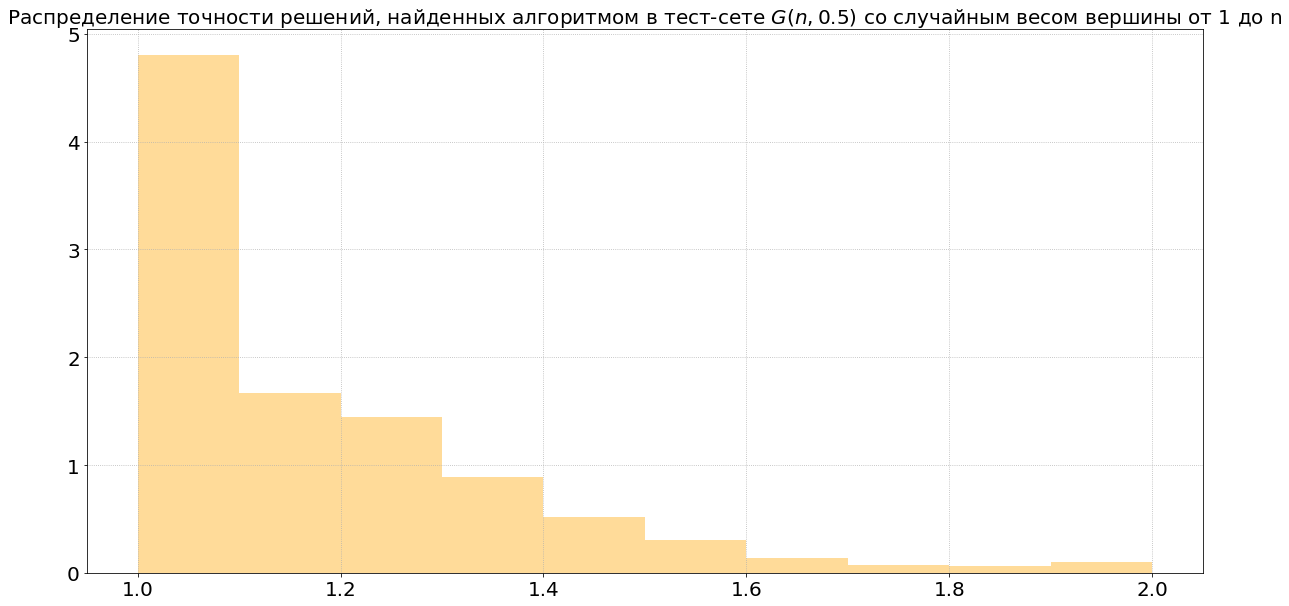

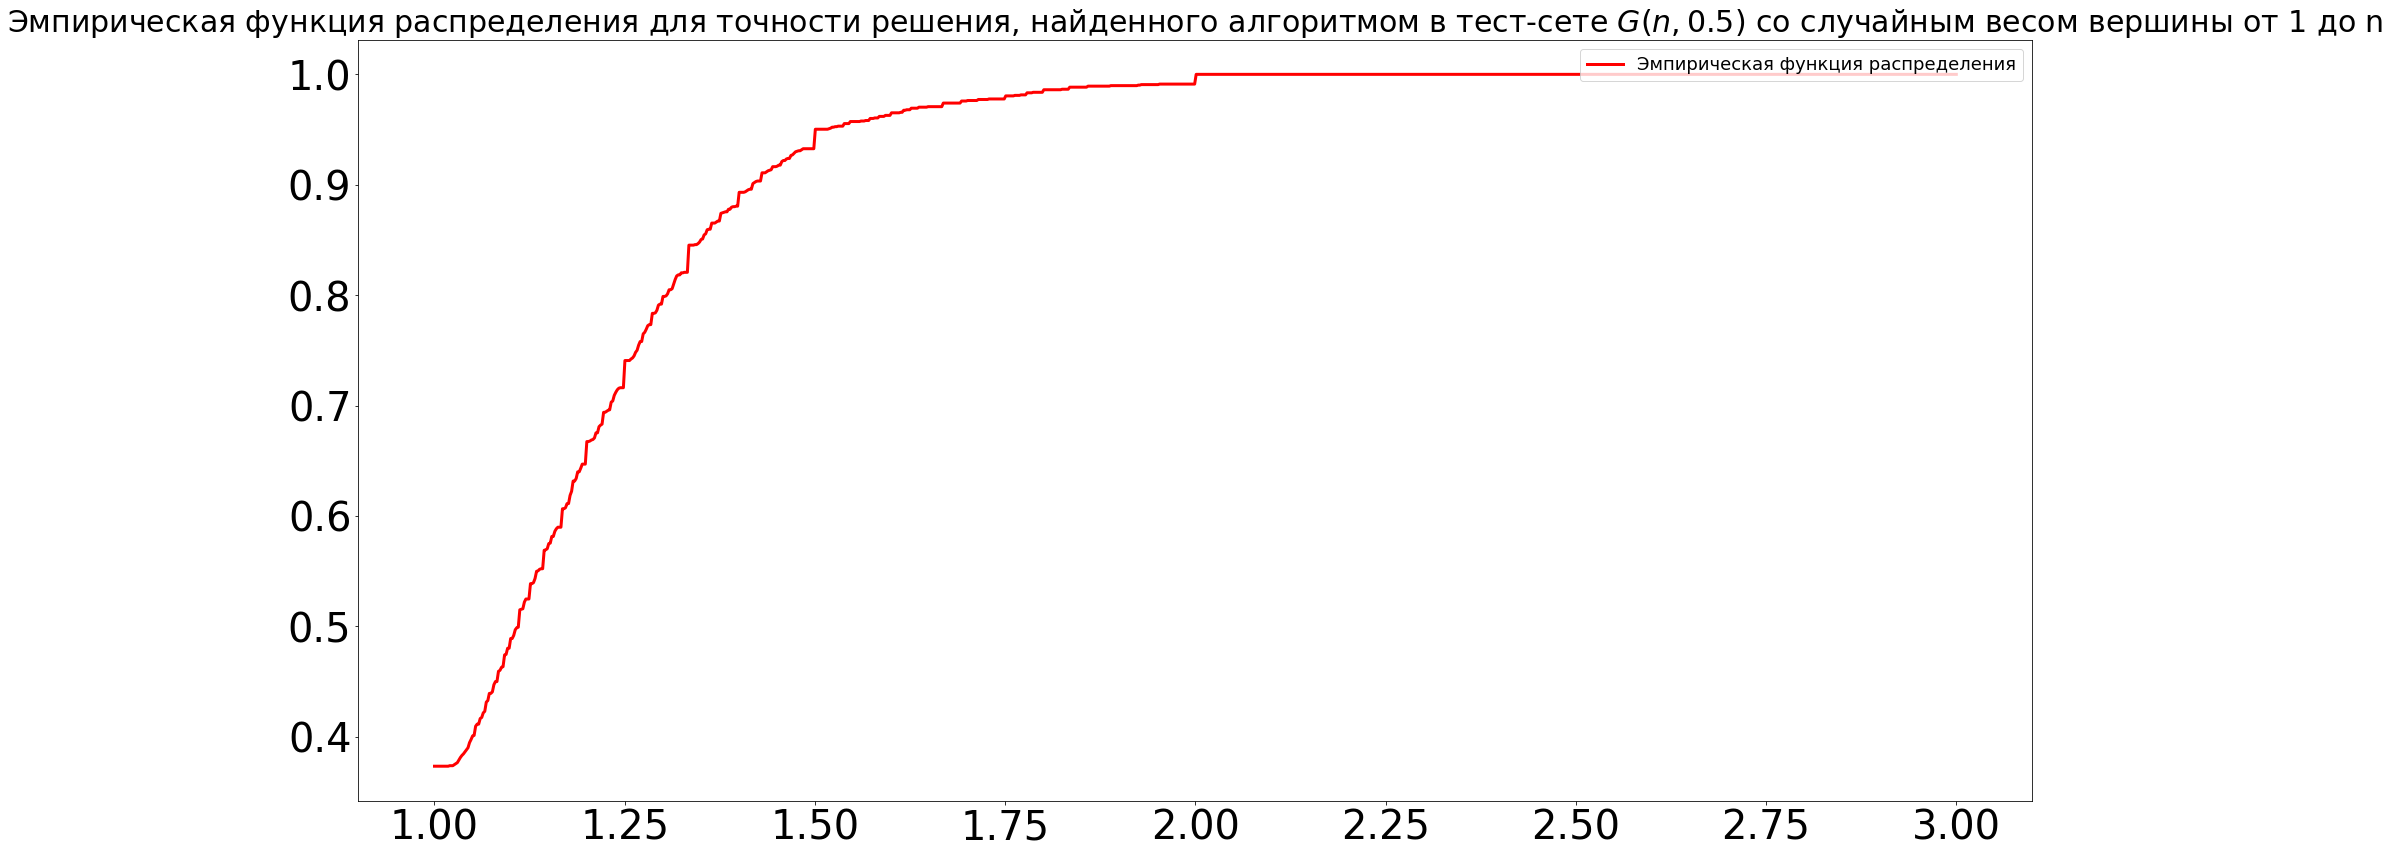

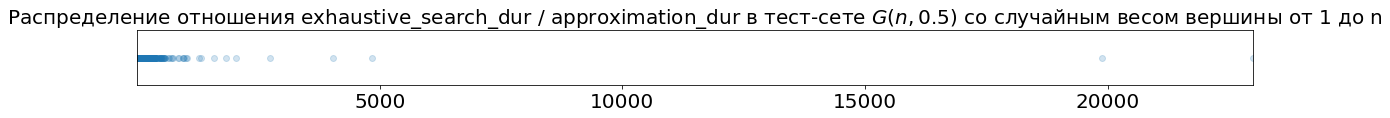

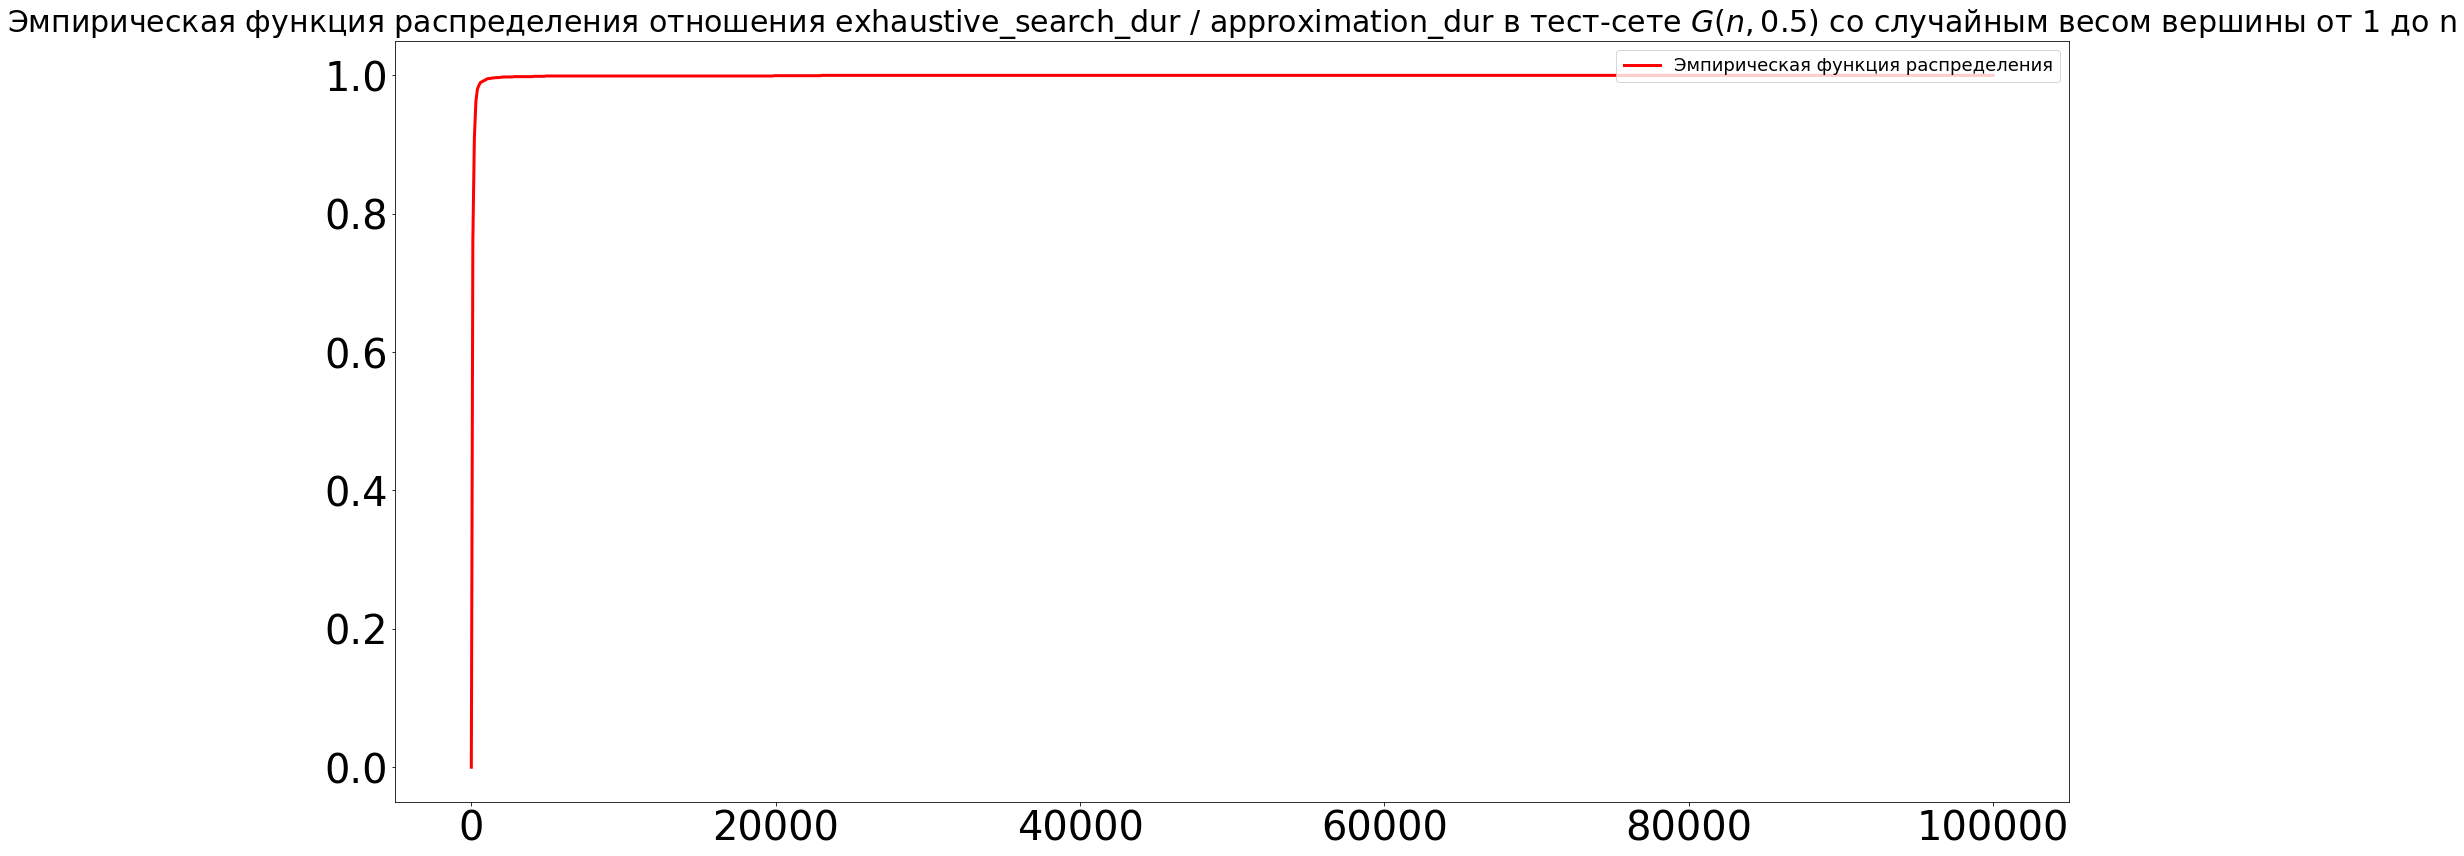

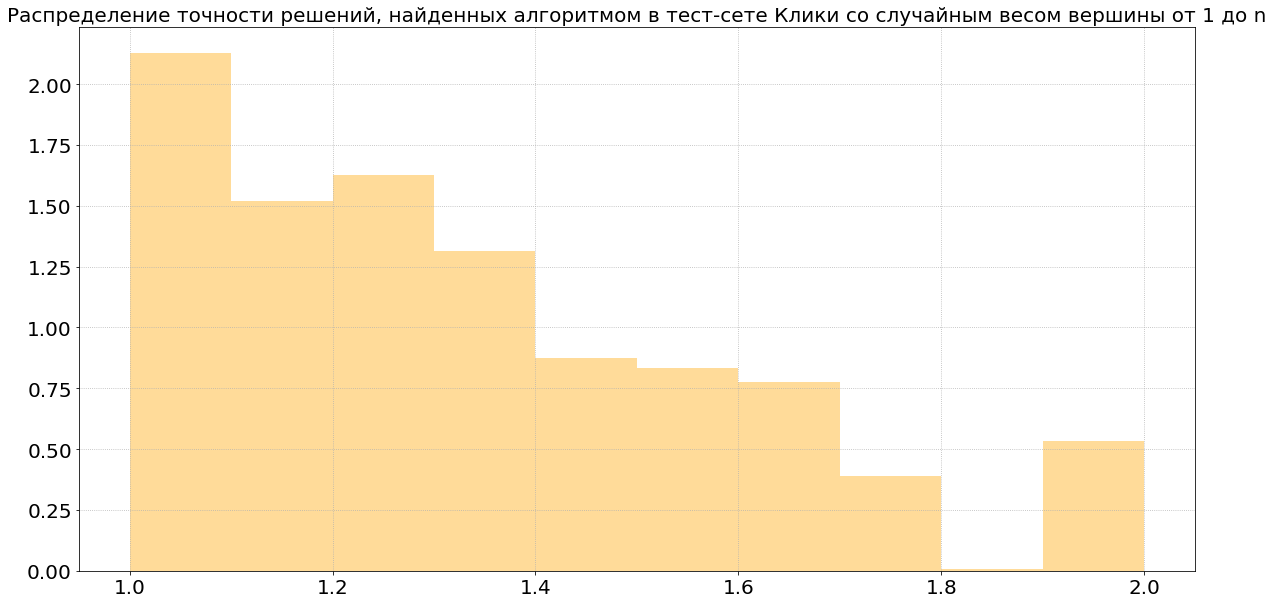

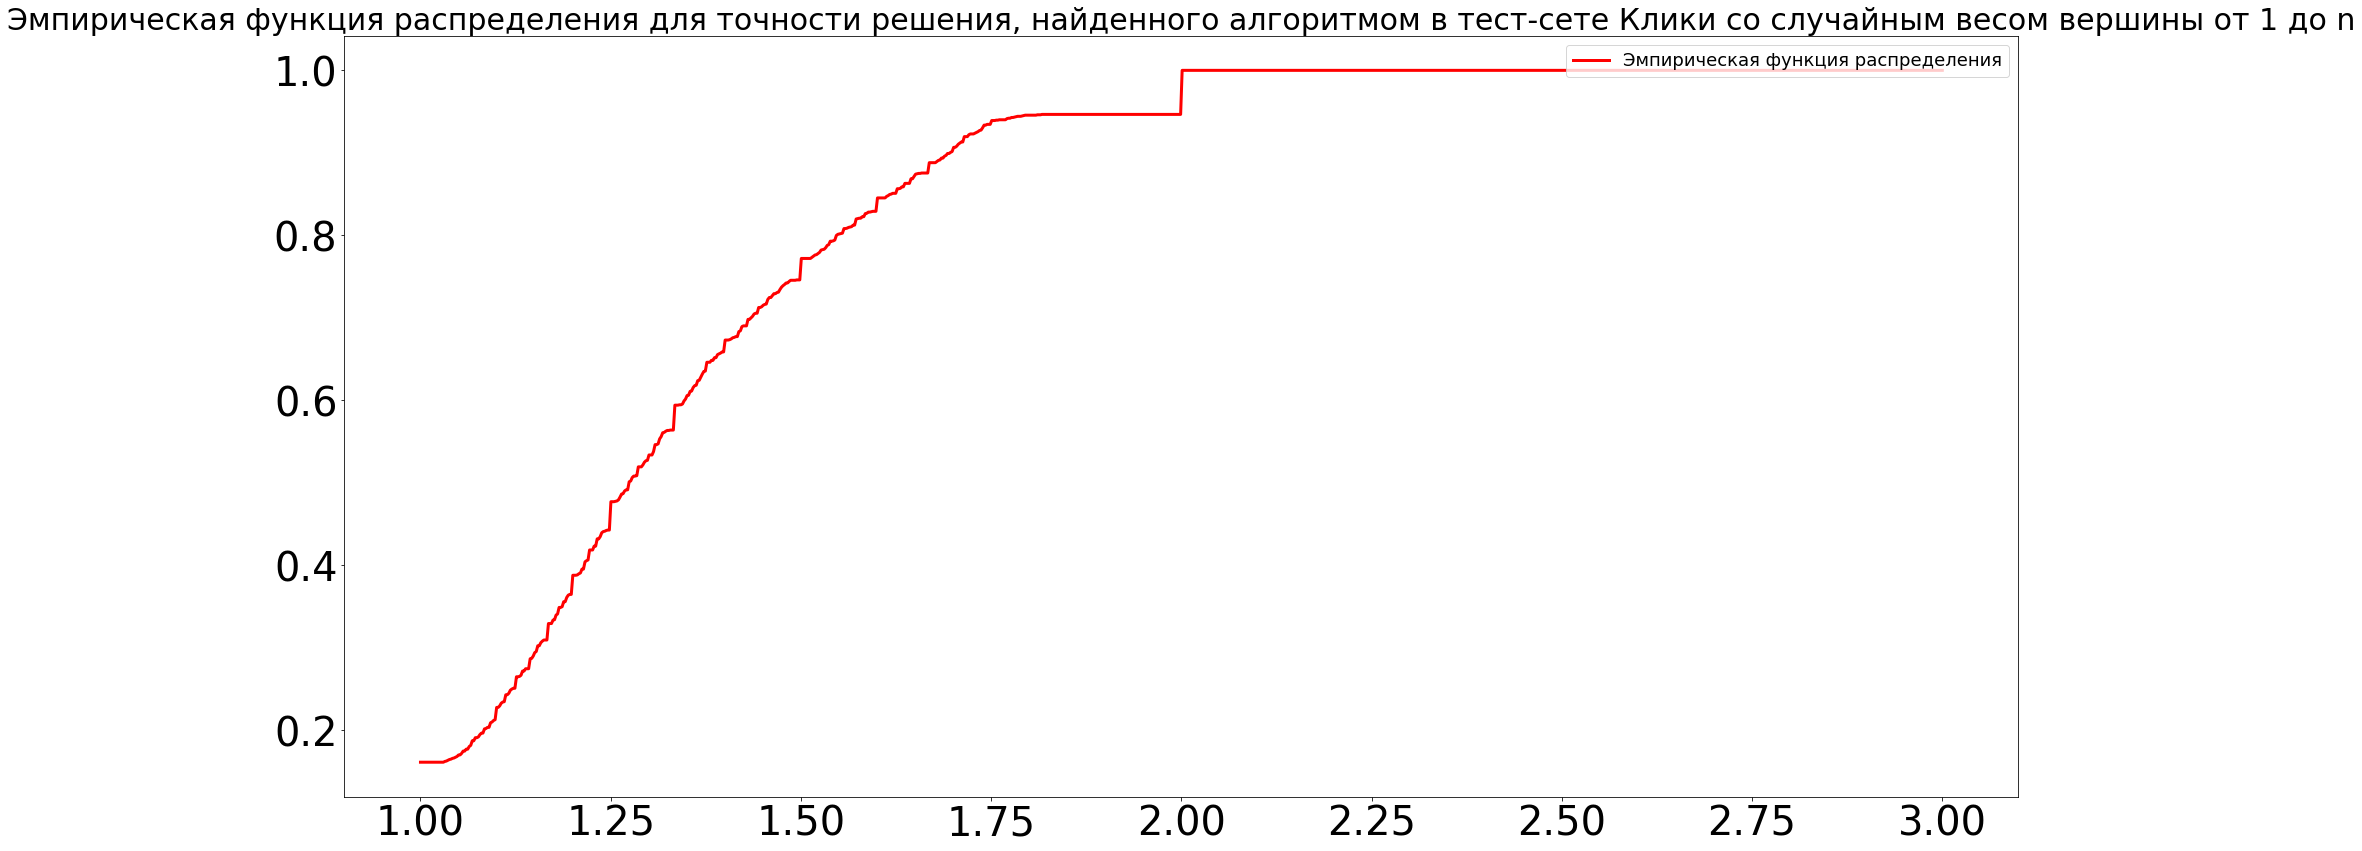

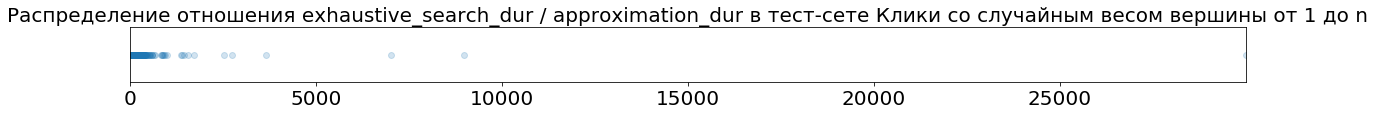

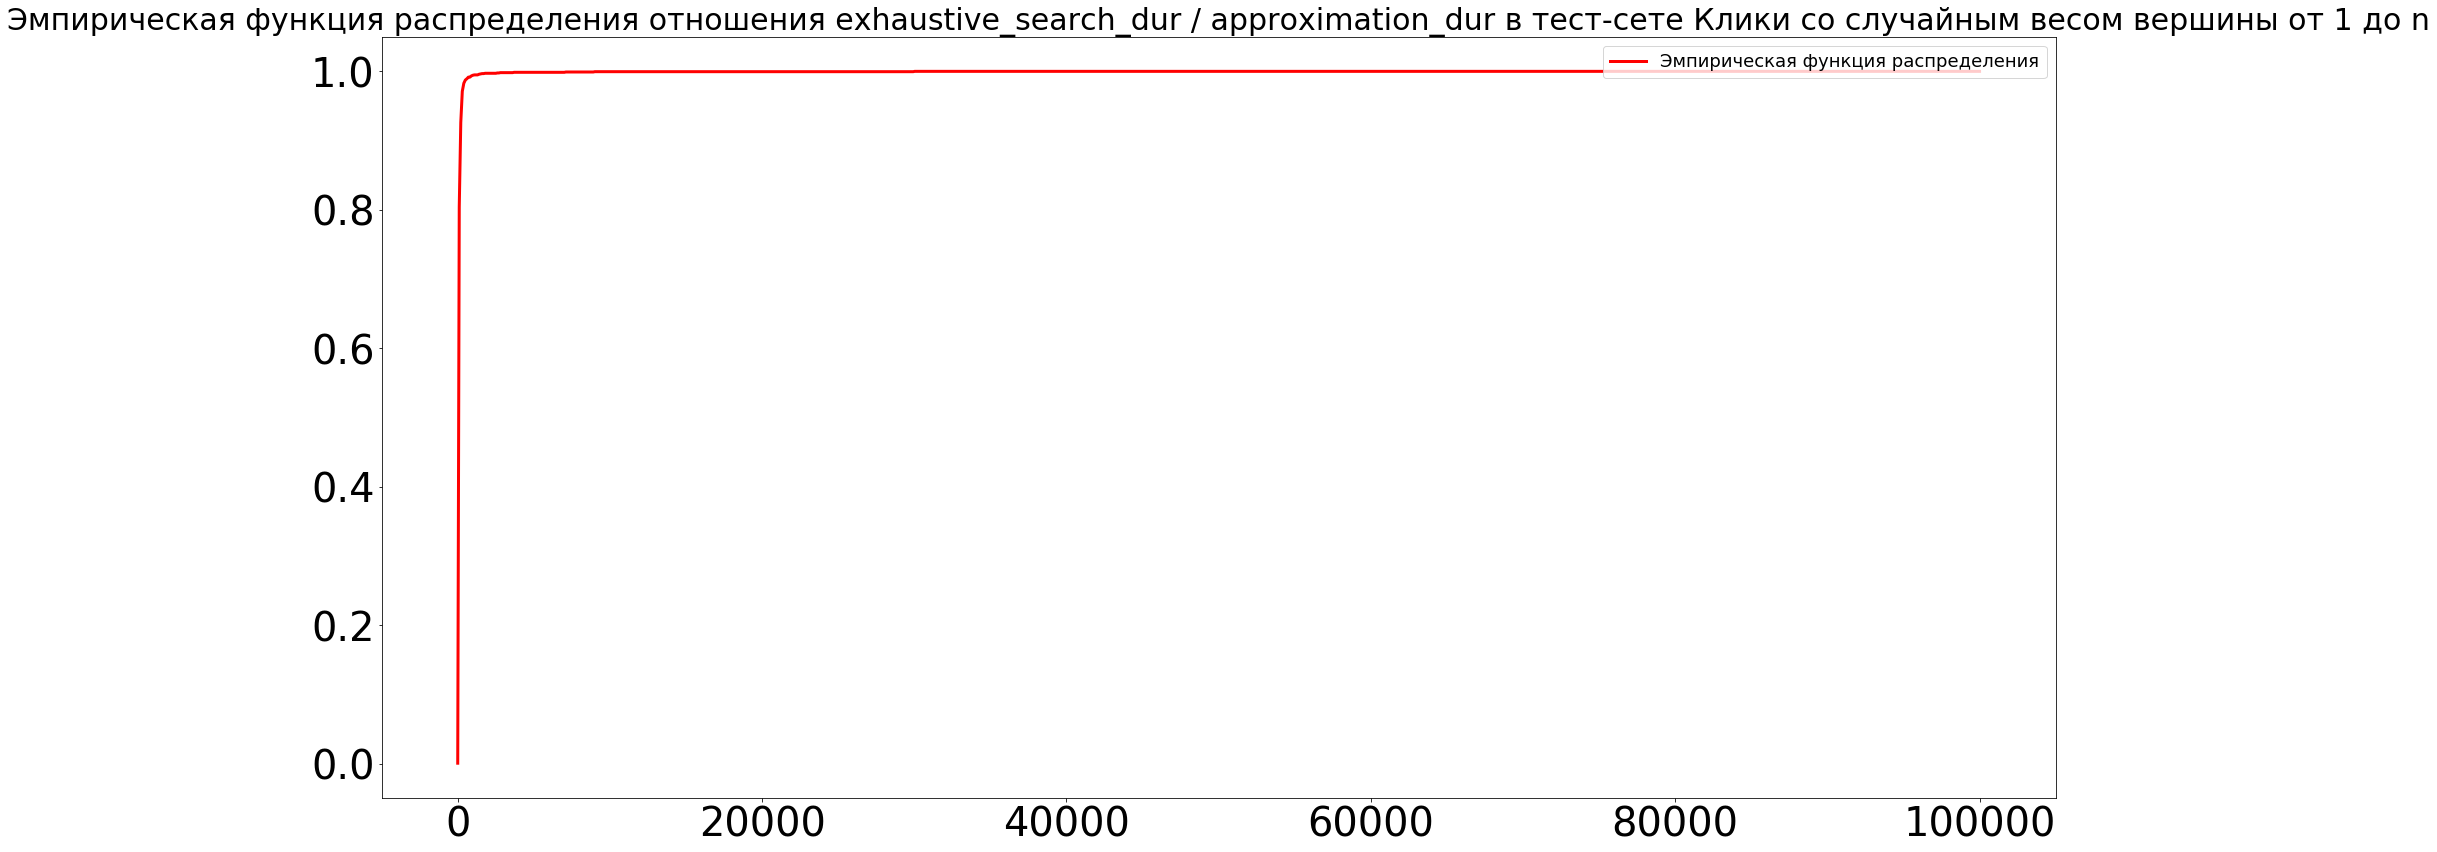

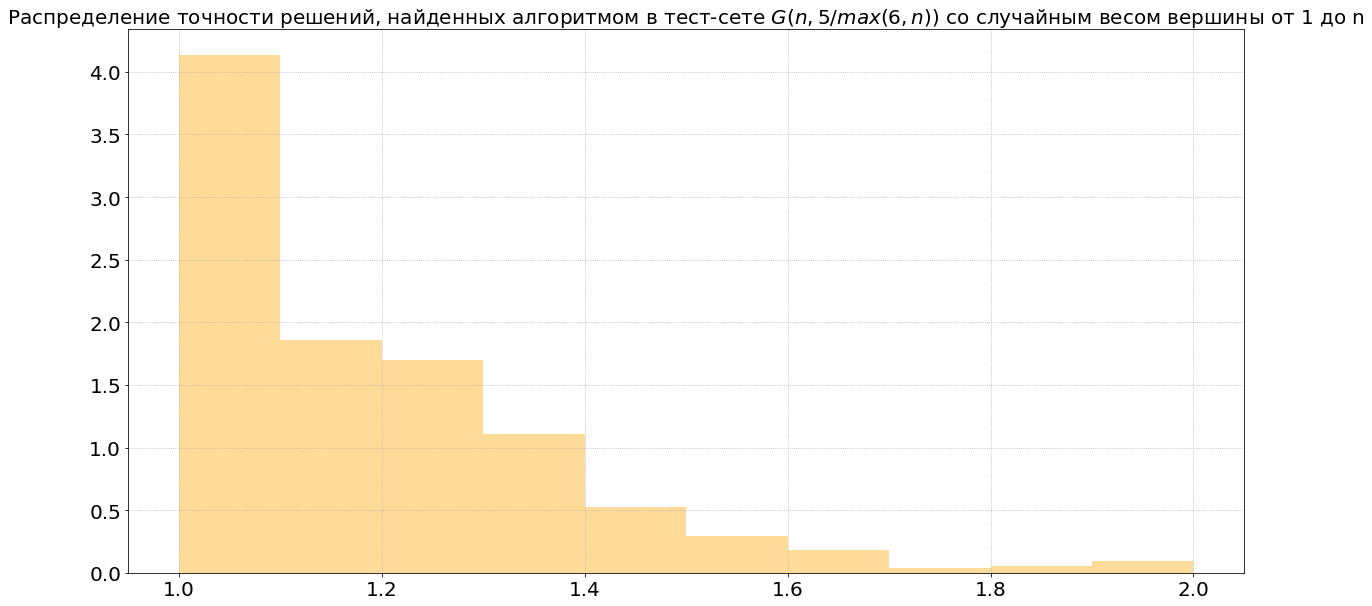

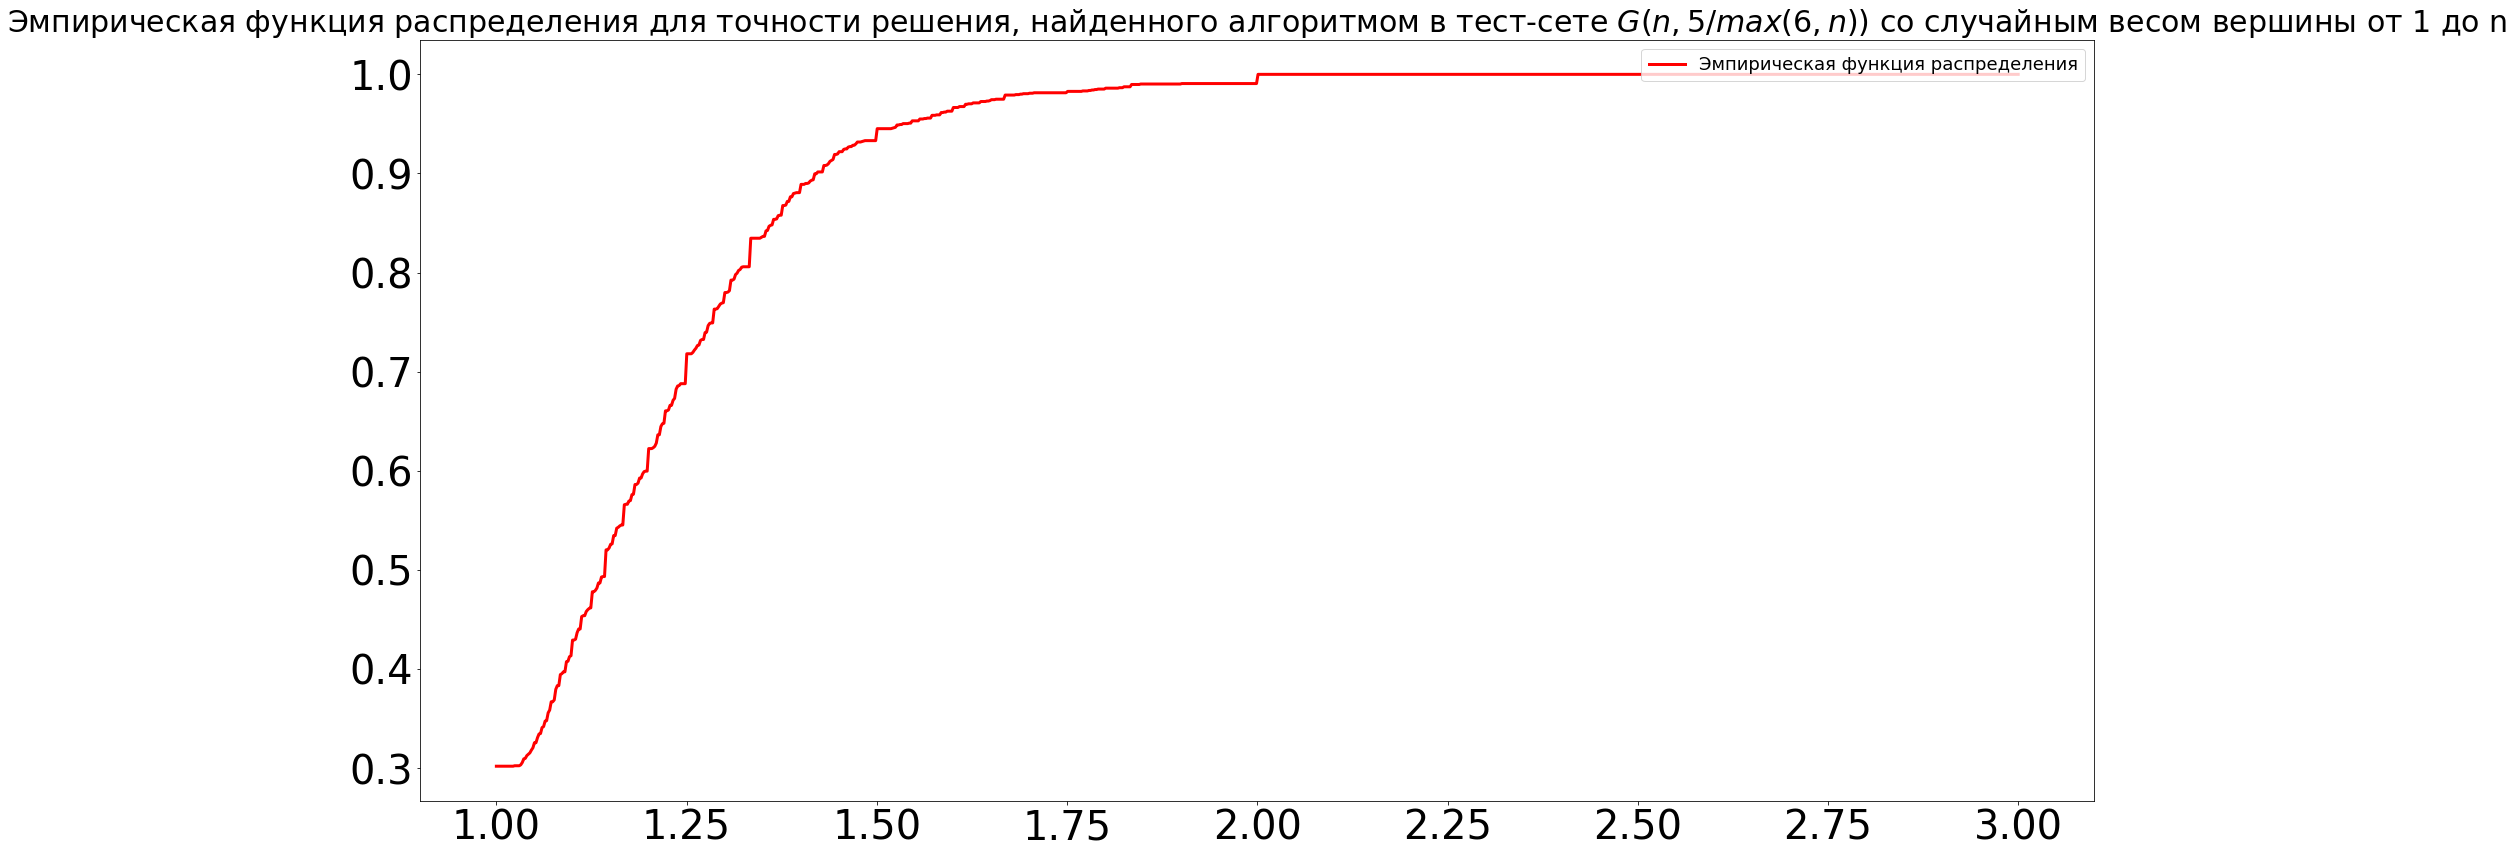

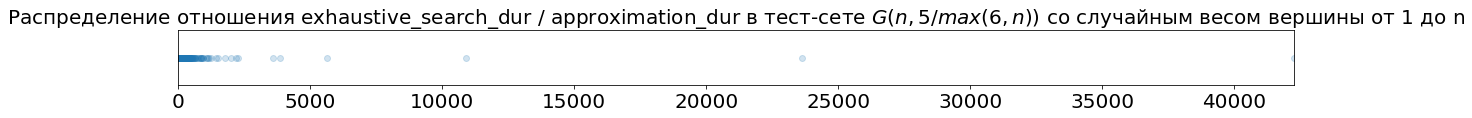

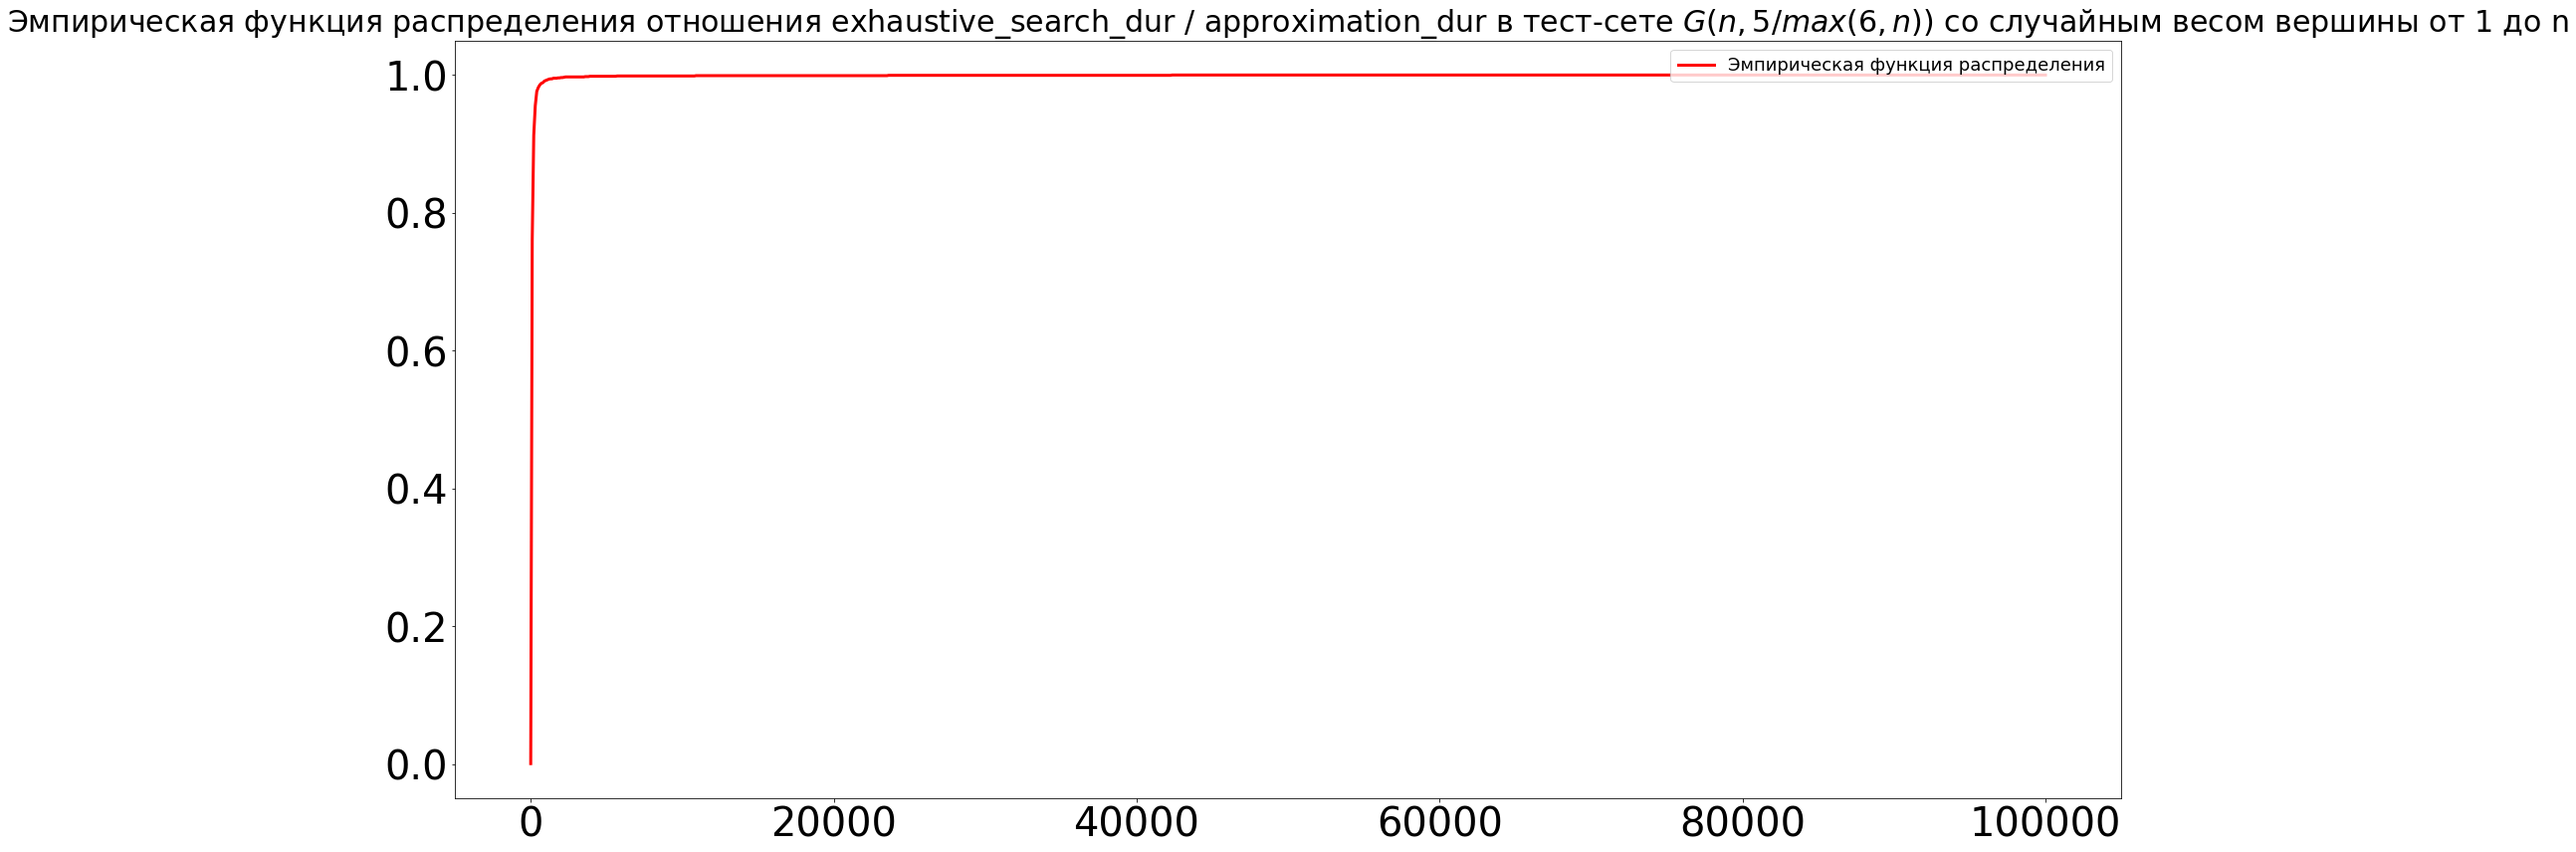

In [53]:
infile_name = './tests_input/in.txt'
outfile_name = './tests_output/out.txt'

vertex_counts = range(3, 21)
graph_counts = [2, 10, 100, 200, 300, 400, 400, 400, 200,
                100, 20, 10, 5, 2, 1, 1, 1, 1]

weight_param = lambda vertex_count : vertex_count

p = lambda vertex_count : 0.5
analyse_tests(infile_name, outfile_name, p, weight_param,
              vertex_counts, graph_counts,
              '$G(n, 0.5)$ со случайным весом вершины от 1 до n')

p = lambda vertex_count : 1
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              'Клики со случайным весом вершины от 1 до n')

p = lambda vertex_count : 5 / np.max([6, vertex_count])
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              '$G(n, 5 / max(6, n))$ со случайным весом вершины от 1 до n')

**Вывод:**

На случайных графах $G(n, 0.5), G(n, 5 / max(6, n))$, кликах с весовой функцией, равномерно распределенной на множестве $\{ 1, \ldots, n \}$, в среднем достигается довольно высокая точность (в среднем решение хуже оптимального в 1.1 раз), но на некоторых тестах достигается и верхняя оценка, т.е. решение в 2 раза хуже оптимального.

Время работы нашего алгоритма в среднем меньше времени работы полного перебора примерно в 80 раз, но на некоторых тестах достигается и значение 33 000.

Statistics for test-set $G(n, 0.5)$ с весом вершины 1:
Is correct vertex cover: 1.0
Approximation results:
max: 2.0
min: 1.0
mean: 1.1134898285385977
median: 1.0
0.25-quantile: 1.0
0.75-quantile: 1.2
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 24143.11304347826
min: 2.2857142857142856
mean: 101.09234847222673
median: 45.903225806451616
0.25-quantile: 22.642857142857142
0.75-quantile: 89.94285714285714

Statistics for test-set Клики с весом вершины 1:
Is correct vertex cover: 1.0
Approximation results:
max: 1.5
min: 1.0526315789473684
mean: 1.1408116248498987
median: 1.125
0.25-quantile: 1.1111111111111112
0.75-quantile: 1.1666666666666667
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 93295.55737704918
min: 1.5
mean: 200.33375127127374
median: 57.333333333333336
0.25-quantile: 22.846153846153847
0.75-quantile: 135.3181818181818

Statistics for test-set $G(n, 5 / max(6, n))$ с весом вершины 1:
Is correct vertex cover: 1.0
Approximat

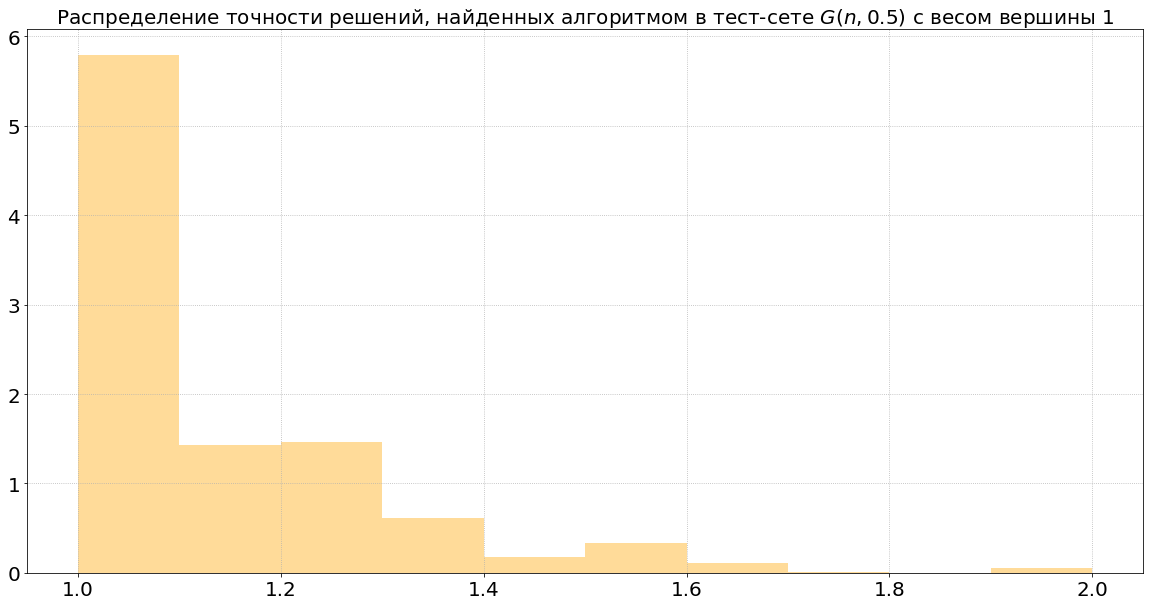

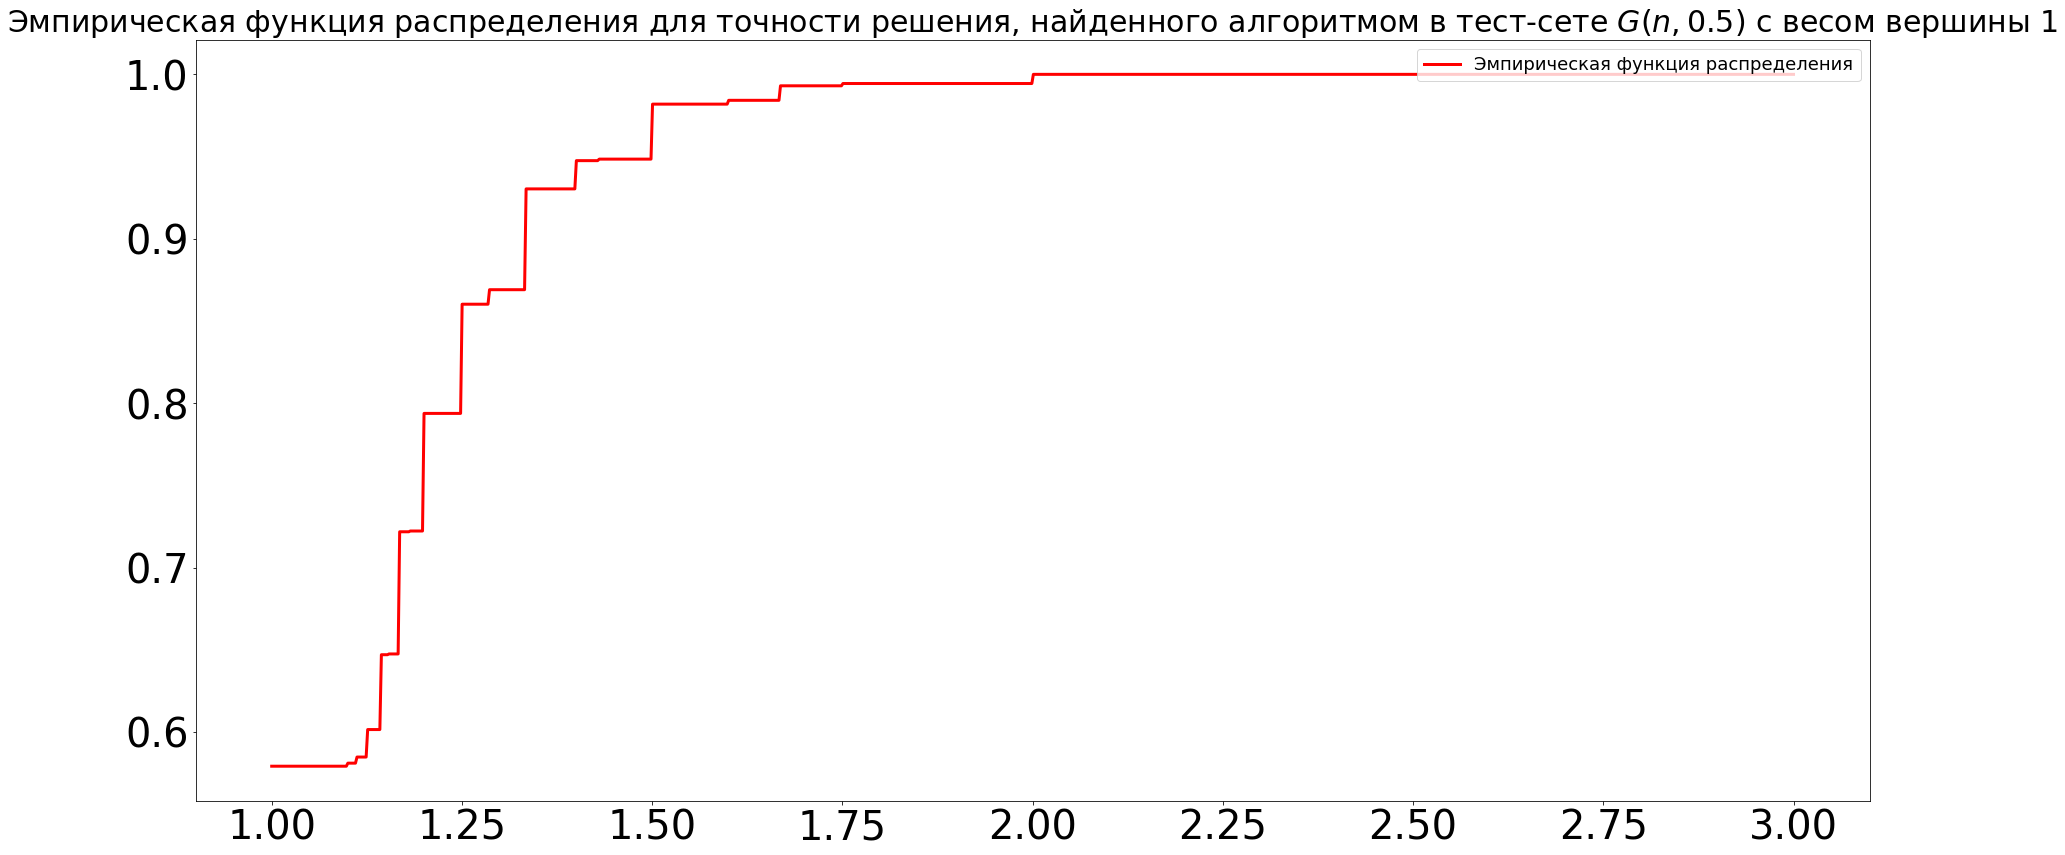

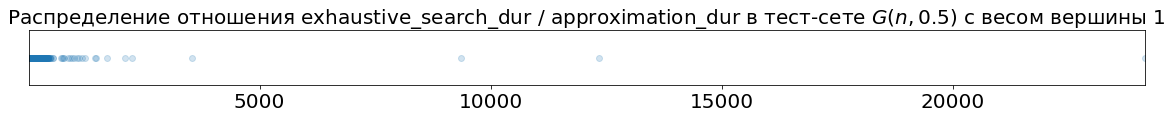

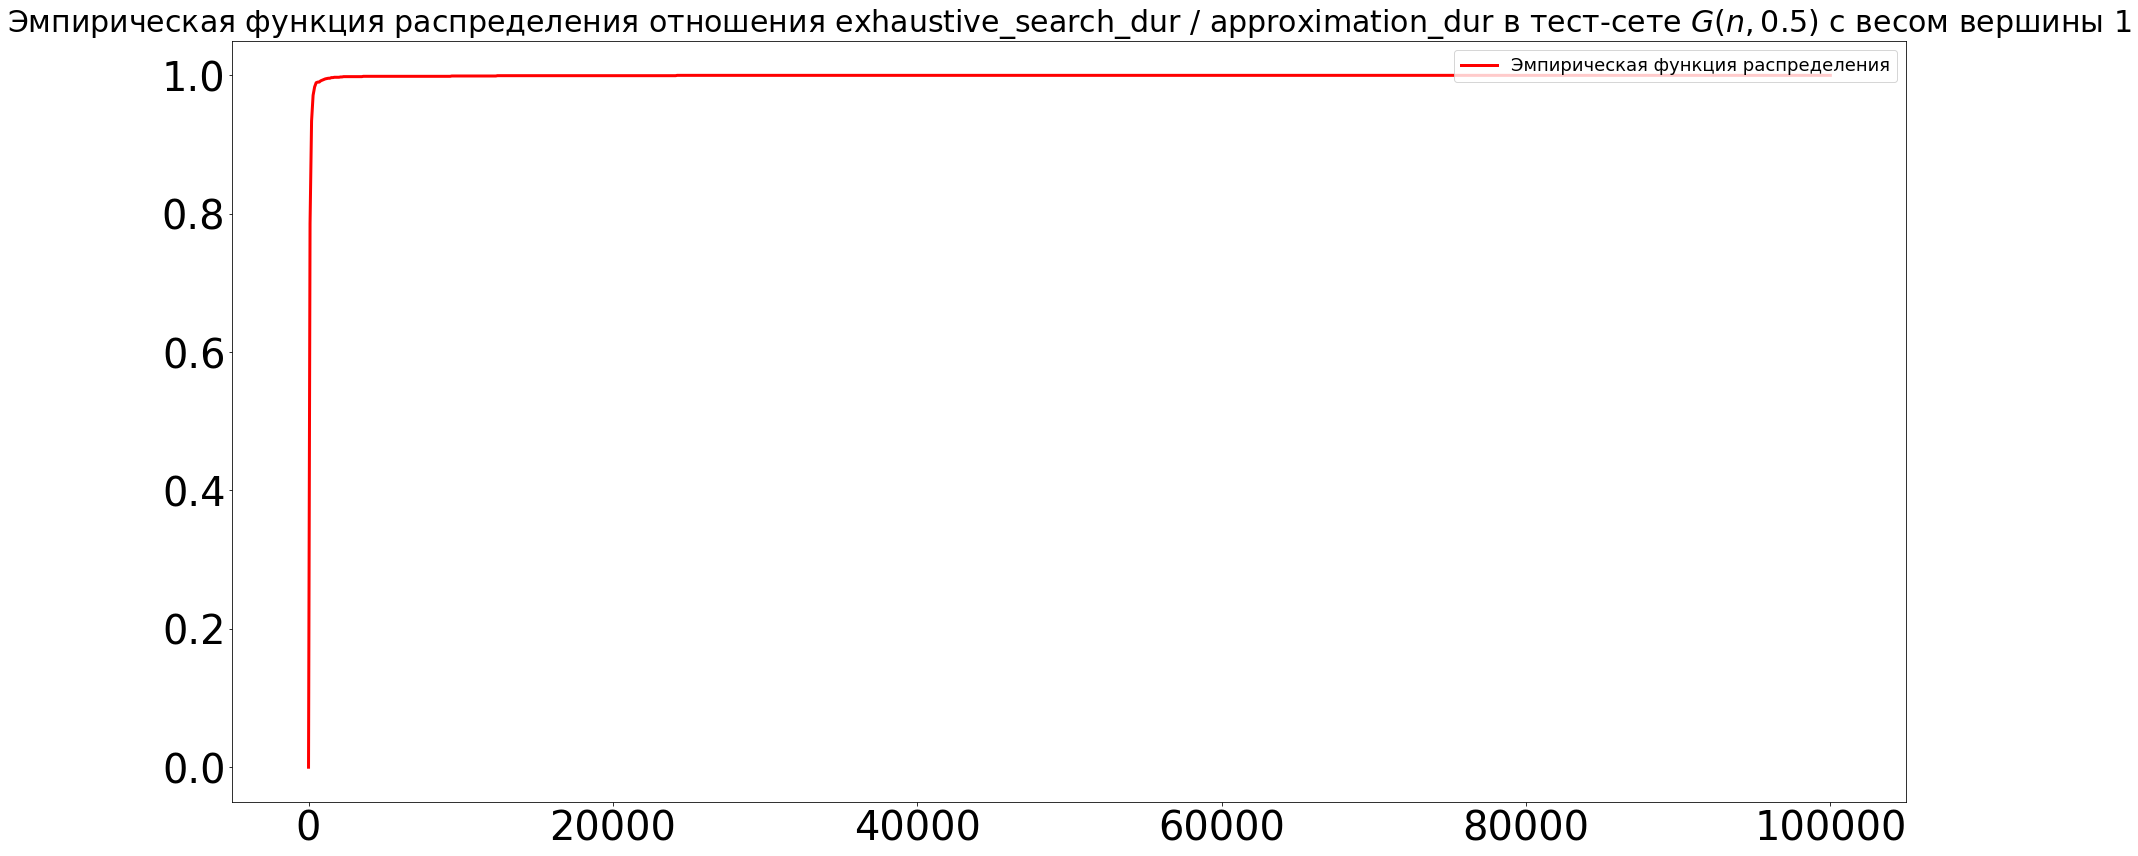

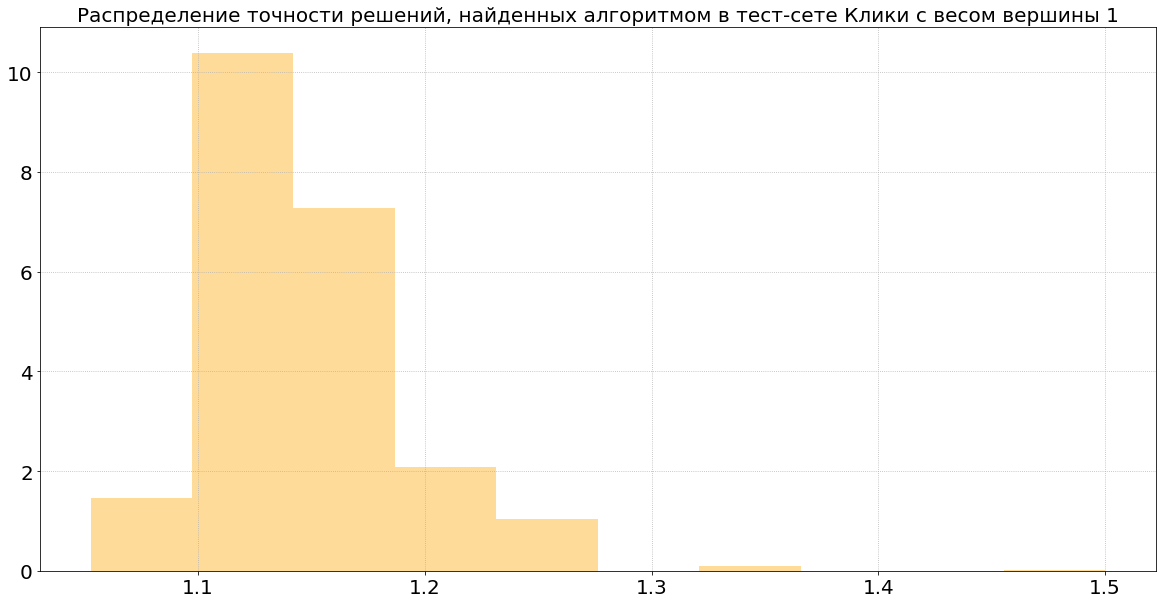

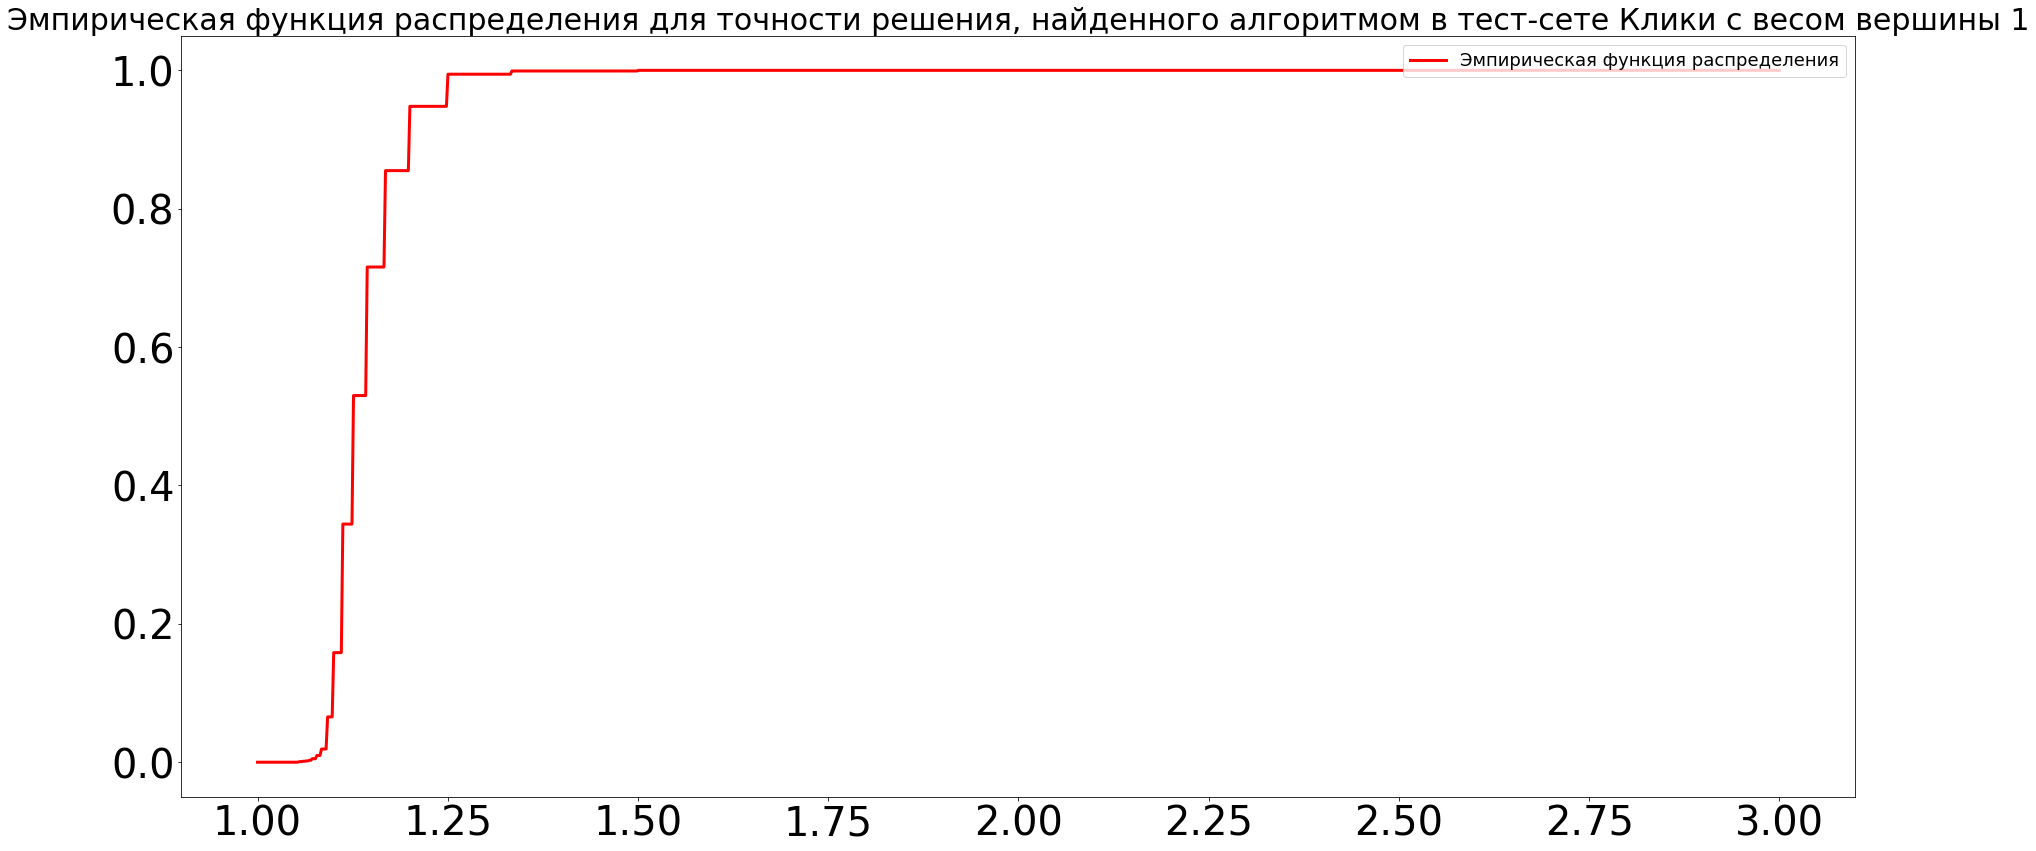

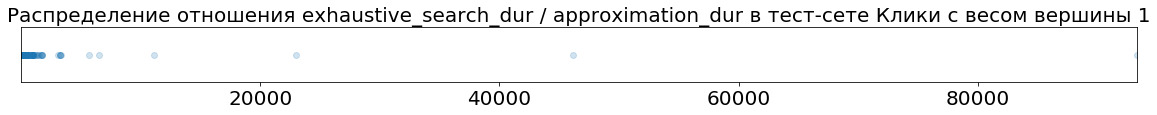

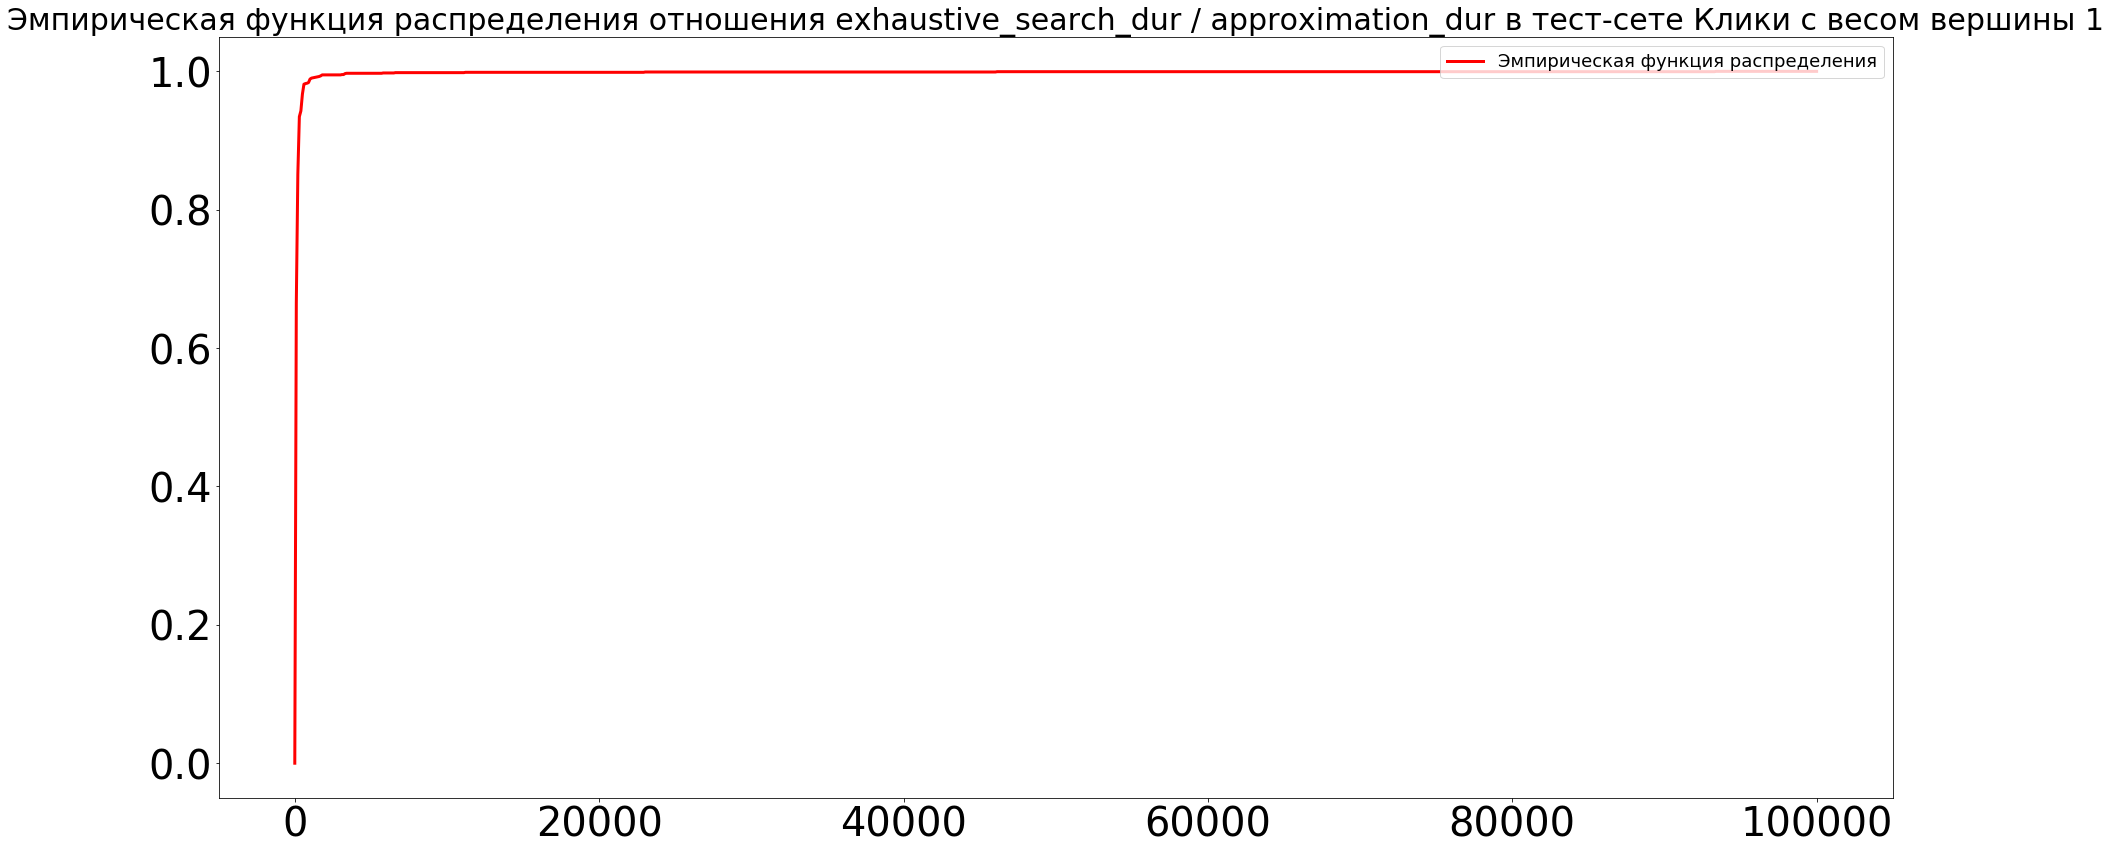

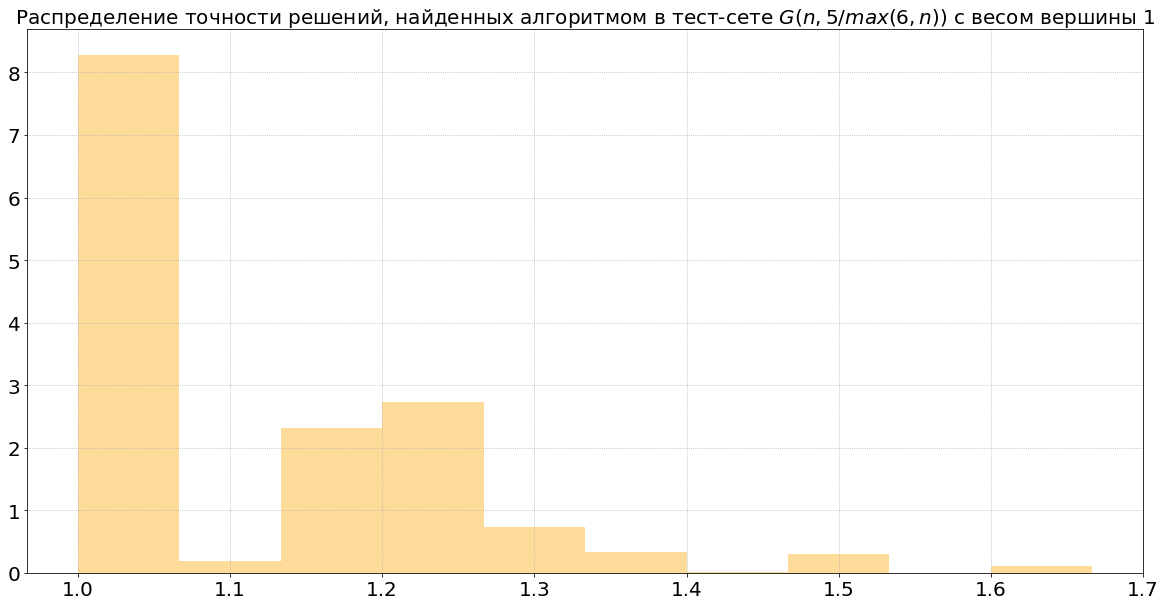

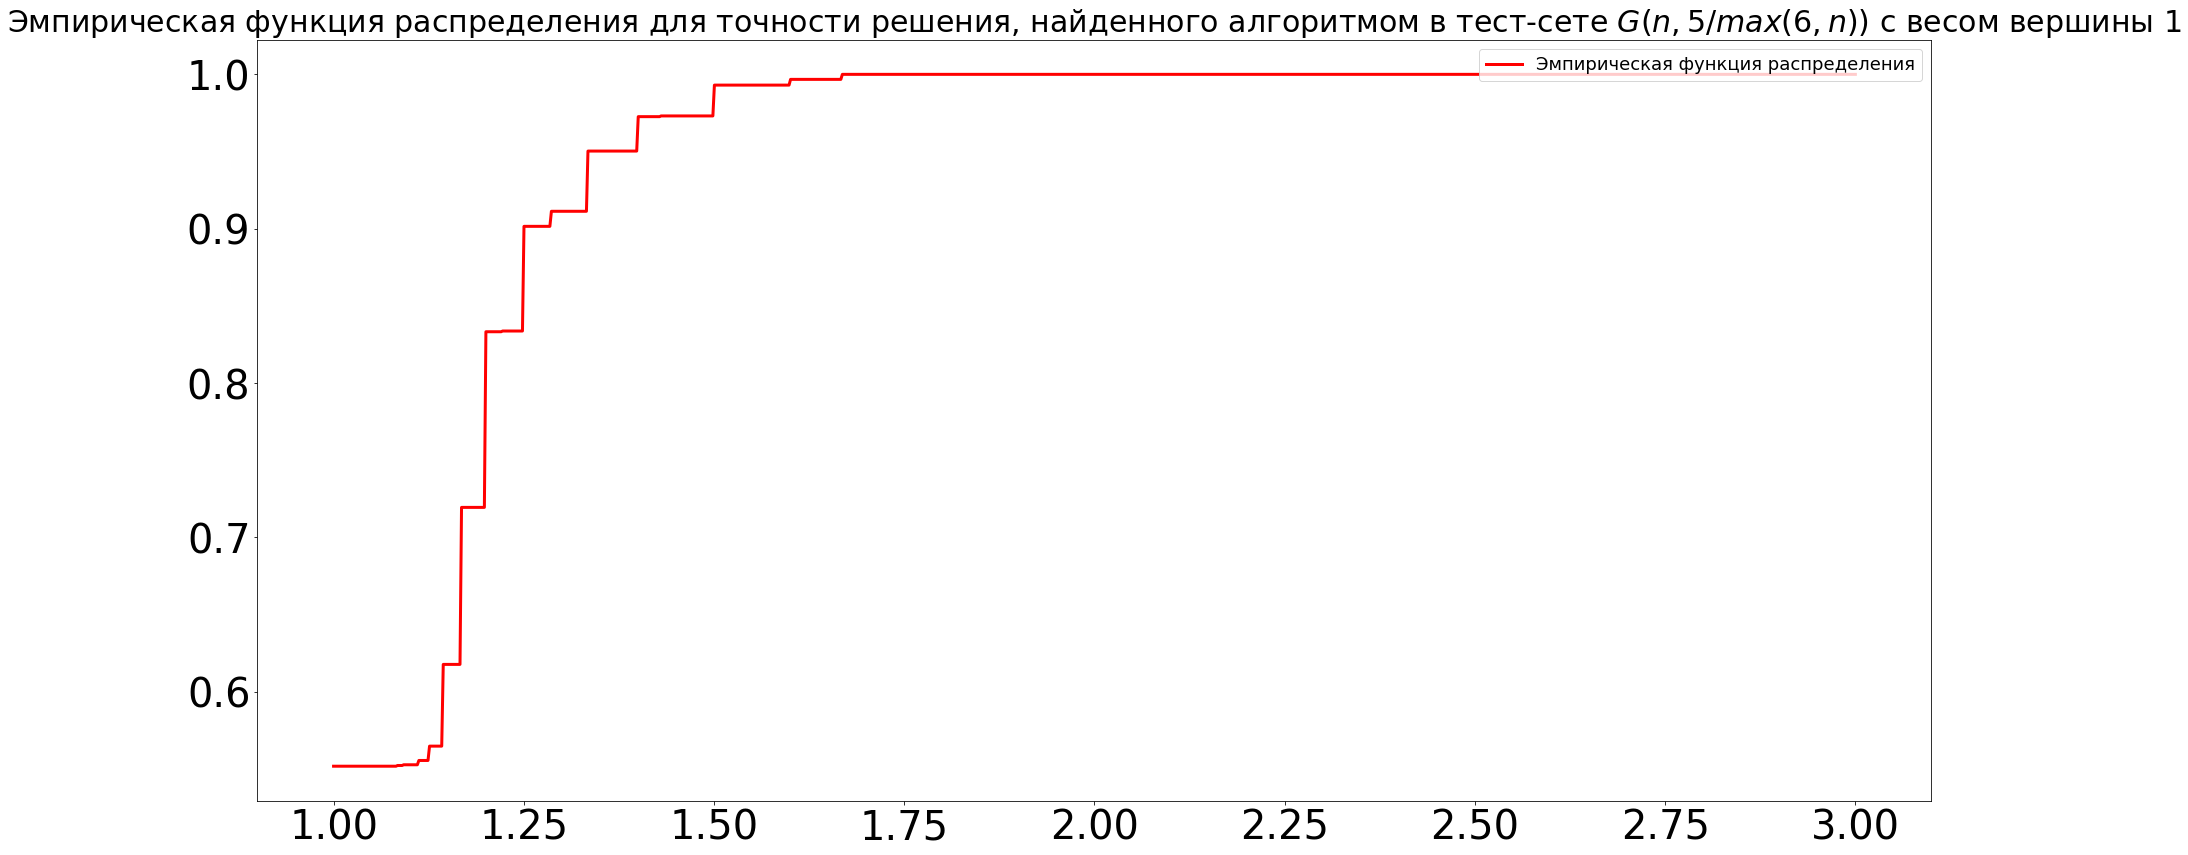

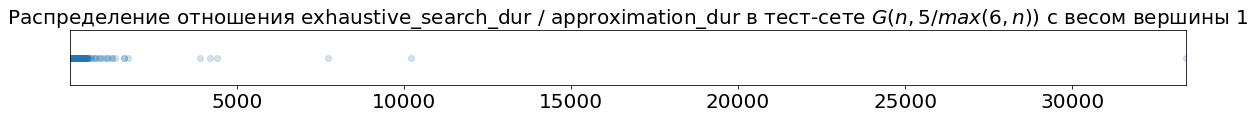

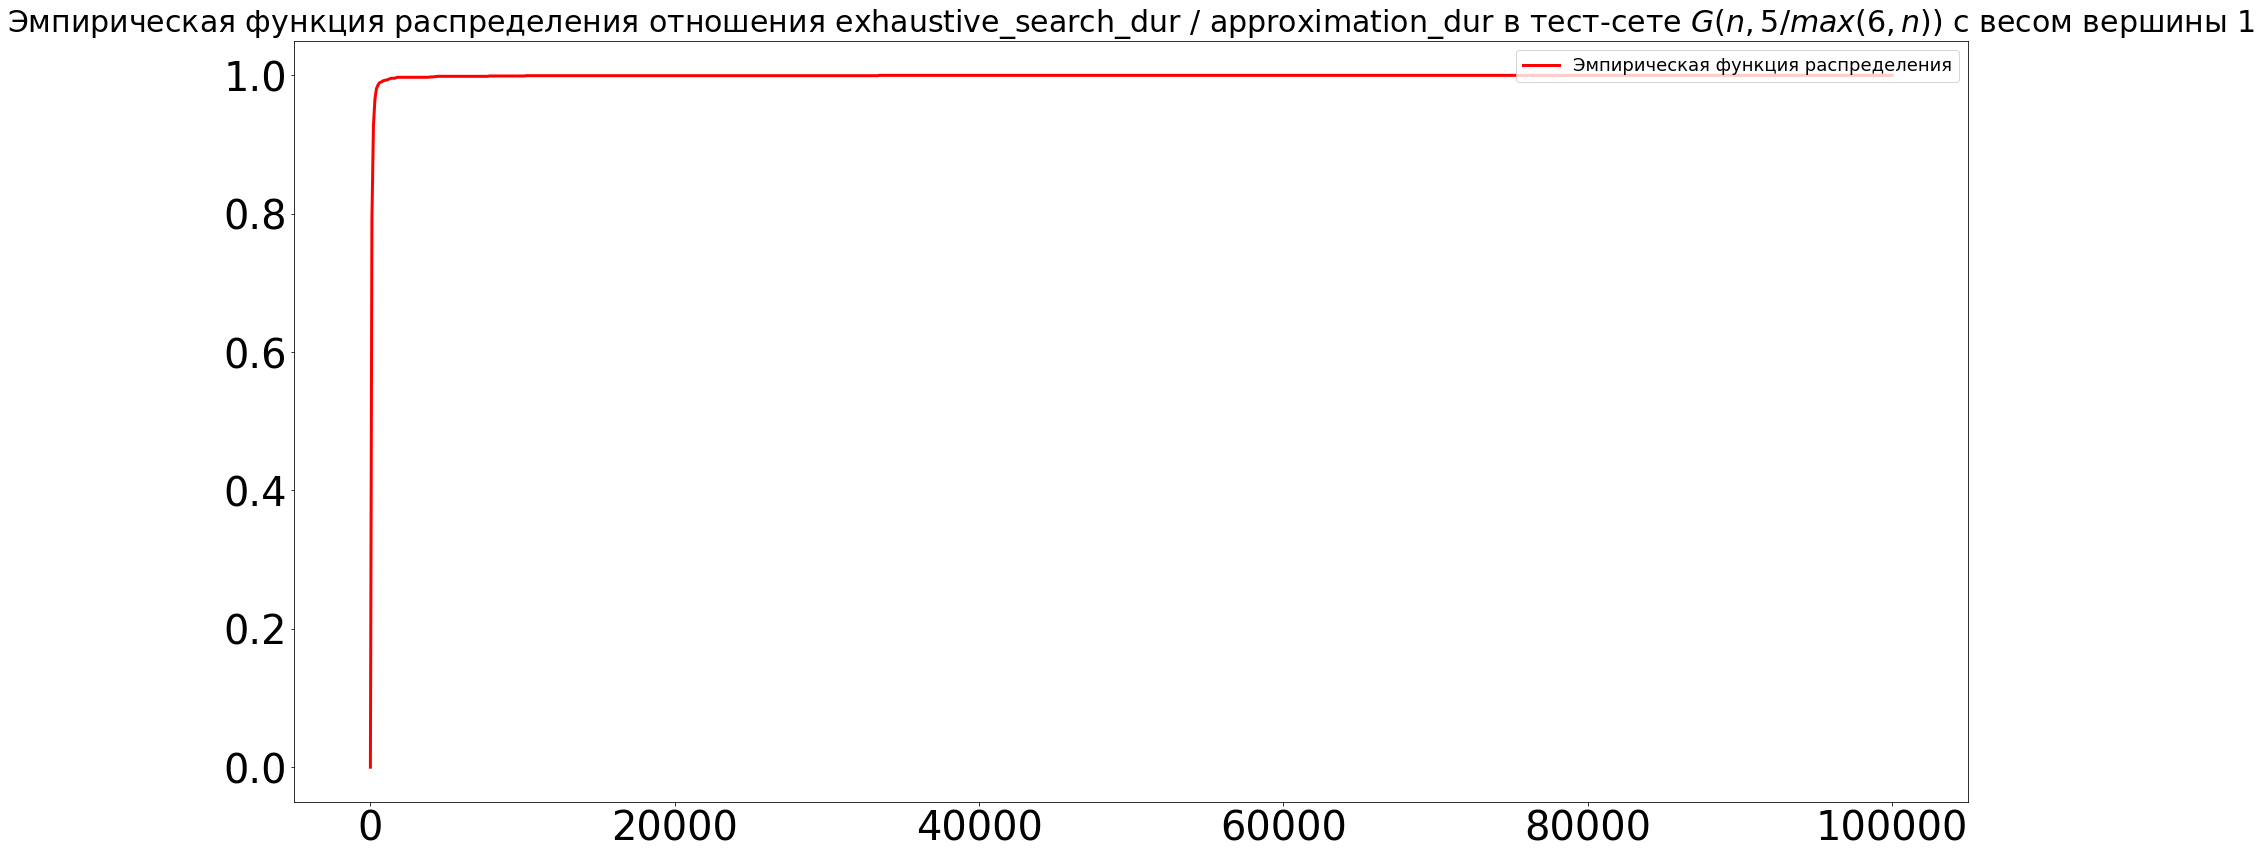

In [47]:
infile_name = './tests_input/in.txt'
outfile_name = './tests_output/out.txt'

vertex_counts = range(3, 21)
graph_counts = [2, 10, 100, 200, 300, 400, 400, 400, 200,
                100, 20, 10, 5, 2, 1, 1, 1, 1]

weight_param = lambda vertex_count : 1

p = lambda vertex_count : 0.5
analyse_tests(infile_name, outfile_name, p, weight_param,
              vertex_counts, graph_counts,
              '$G(n, 0.5)$ с весом вершины 1')

p = lambda vertex_count : 1
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              'Клики с весом вершины 1')

p = lambda vertex_count : 5 / np.max([6, vertex_count])
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              '$G(n, 5 / max(6, n))$ с весом вершины 1')

**Вывод:**

Если сделать весовую функцию всюду равной 1, то точность тоже остаётся высокой, а время работы нашего алгоритма меньше времени работы полного перебора в большее число раз. В предыдущем запуске тестов в среднем достигалось значение, примерно равное 80, а в этом средние составили:

- 101 для $G(n, 0.5)$;

- 200 для клик;

- 106 для $G(n, 5 / max(6, n))$;

Проведем тесты на двудольных графах с долями, состоящими из $\lfloor \frac{n}{2} \rfloor$ и $\lceil \frac{n}{2} \rceil$ вершин, с вероятностью ребра $p$ и с весовой функцией, всюду равной 1.

In [48]:
# записываем в уже открытый файл file
# ребра случайного двудольного графа с вероятностью ребра p
def write_random_edges(vertex_count, p, file):
    edge_count = 0
    for i in range(vertex_count // 2):
        for j in range(vertex_count // 2, vertex_count):
            frm = i
            to = j

            coin = sps.bernoulli.rvs(p=p, size=1)
            if coin == 1:
                edge_count += 1
                file.write(str(frm) + ' ' + str(to) + '\n')
    
    if edge_count == 0:
        file.write(str(0) + ' ' + str(1) + '\n')

Statistics for test-set Подграф $K_{\lfloor \frac{n}{2} \rfloor,\lceil \frac{n}{2} \rceil}$ с вероятностью ребра 0.5 и с весом вершин 1:
Is correct vertex cover: 1.0
Approximation results:
max: 2.0
min: 1.0
mean: 1.2458002491908668
median: 1.2
0.25-quantile: 1.0
0.75-quantile: 1.4
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 34749.03592814371
min: 1.875
mean: 138.88572268076945
median: 62.166666666666664
0.25-quantile: 28.0
0.75-quantile: 127.07142857142857

Statistics for test-set $K_{\lfloor \frac{n}{2} \rfloor,\lceil \frac{n}{2} \rceil}$ с весом вершин 1:
Is correct vertex cover: 1.0
Approximation results:
max: 2.0
min: 1.0
mean: 1.5220622387366465
median: 2.0
0.25-quantile: 1.0
0.75-quantile: 2.0
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 103650.52727272727
min: 2.6
mean: 231.63303277715988
median: 80.5
0.25-quantile: 31.6
0.75-quantile: 139.4090909090909

Statistics for test-set Подграф $K_{\lfloor \frac{n}{2} \rfloor,\lcei

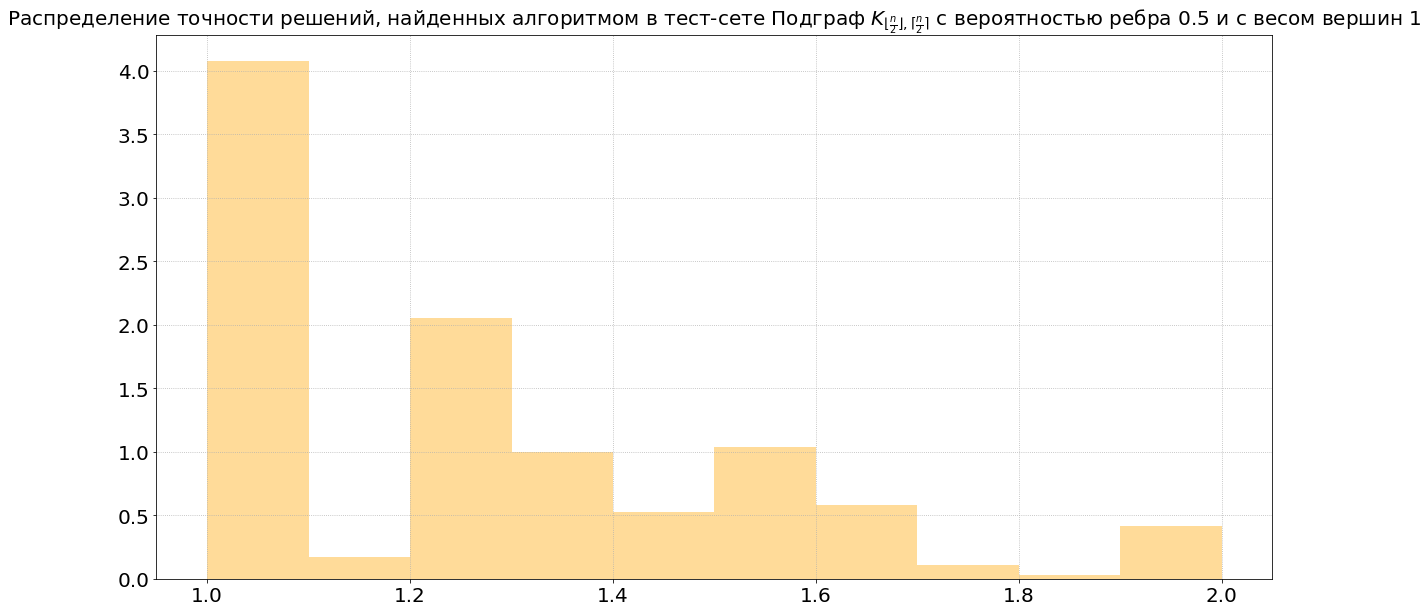

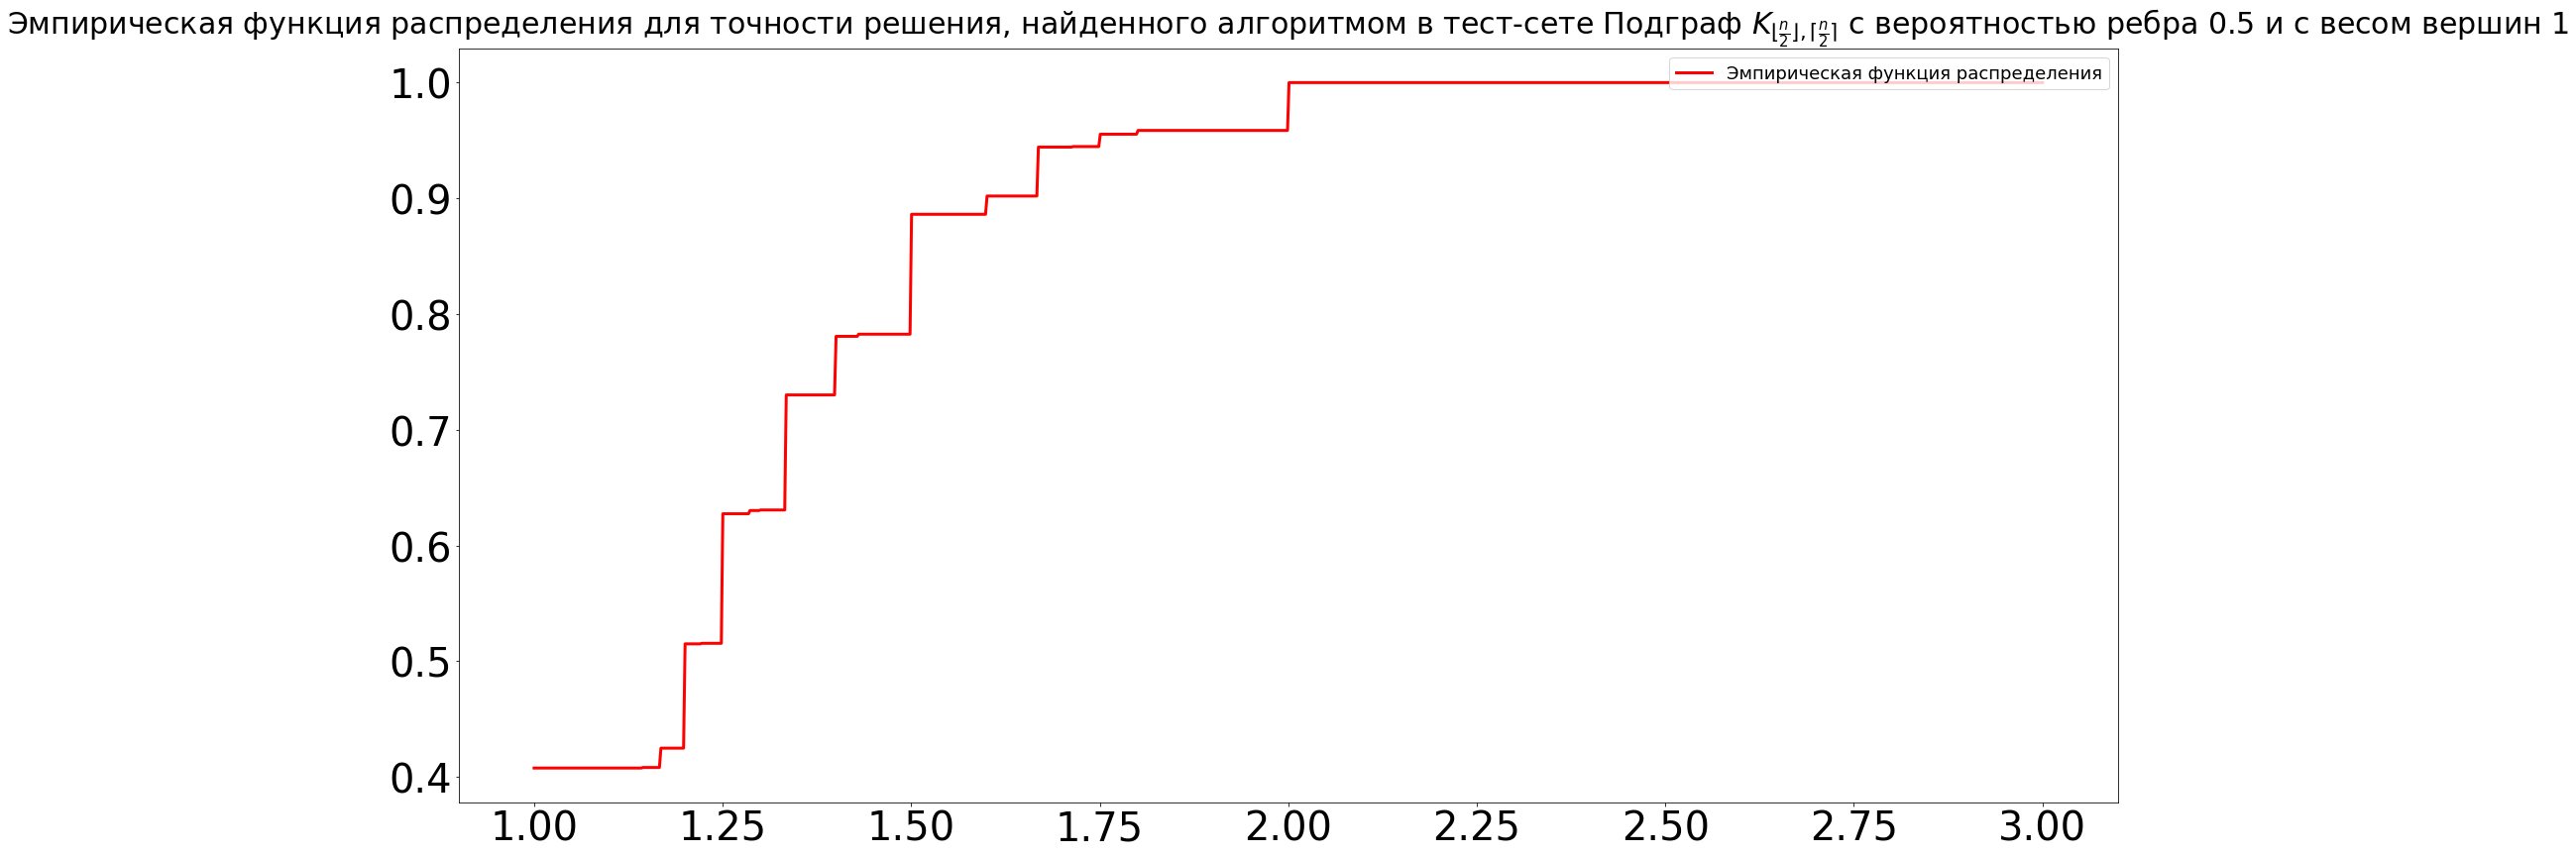

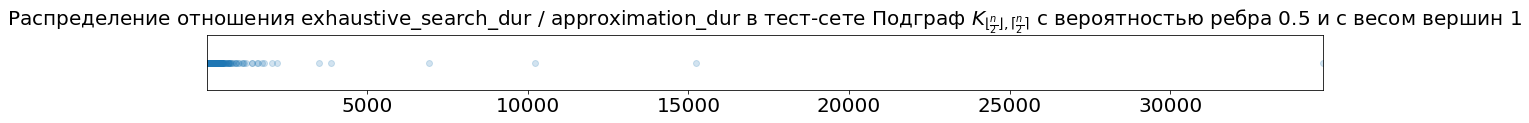

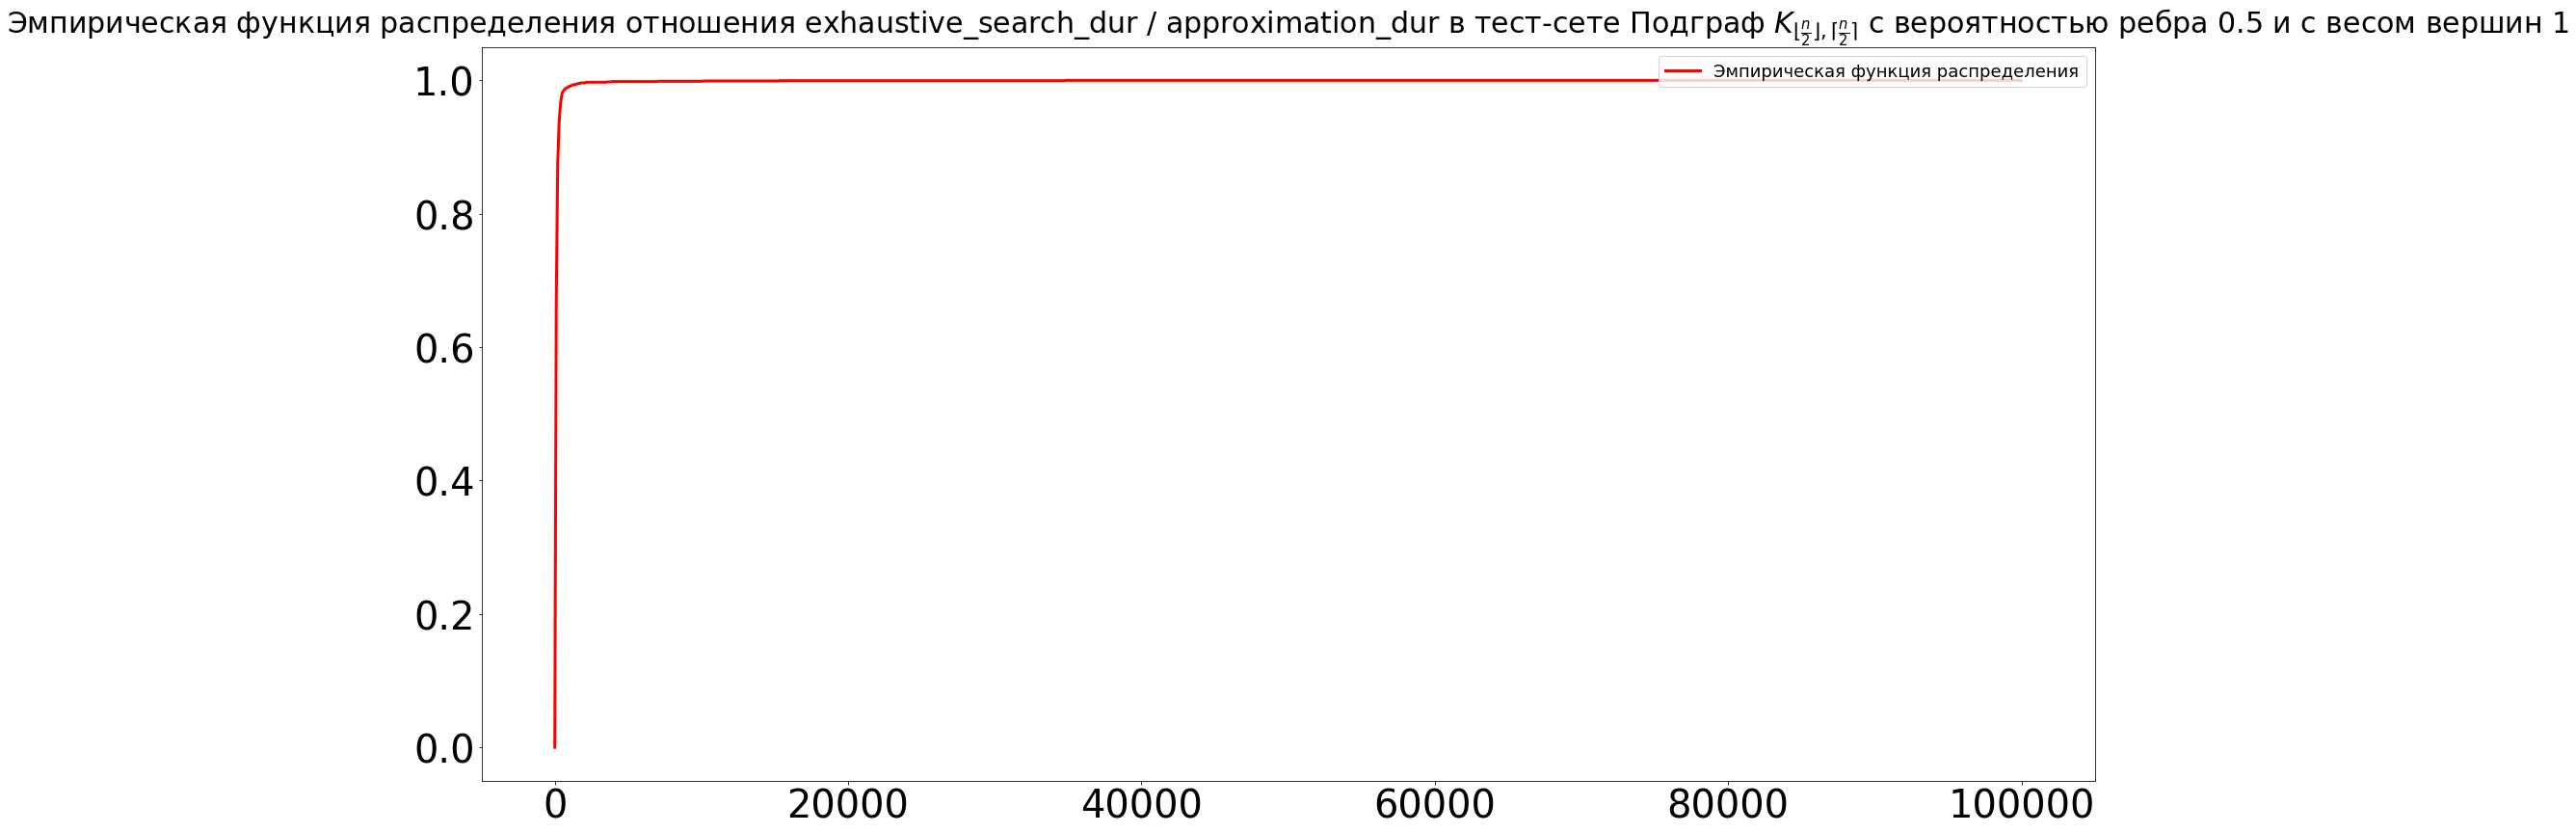

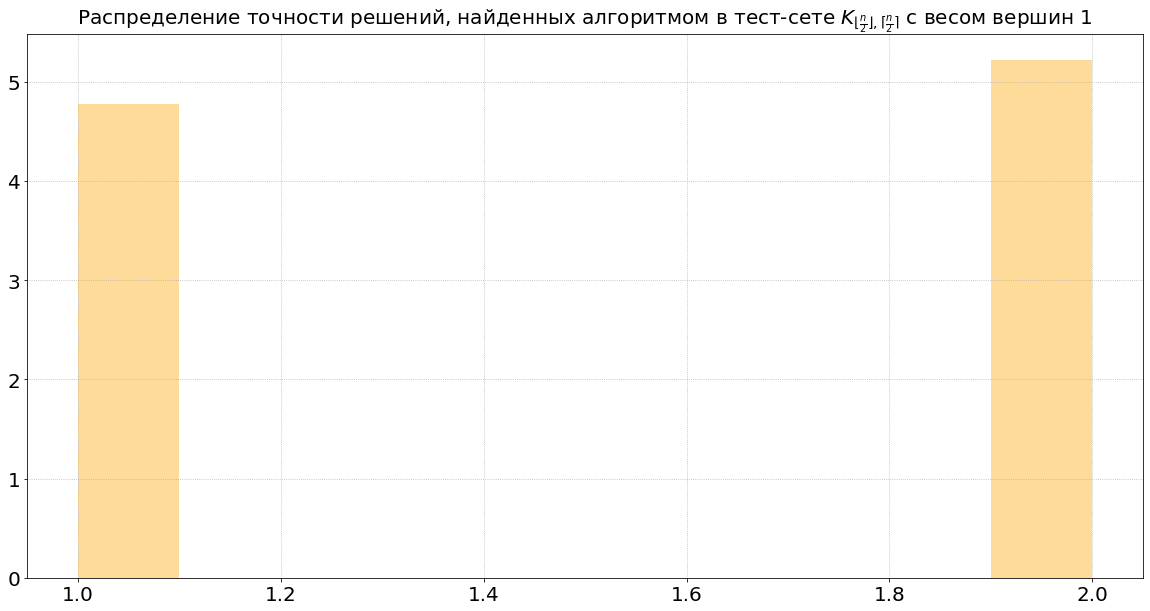

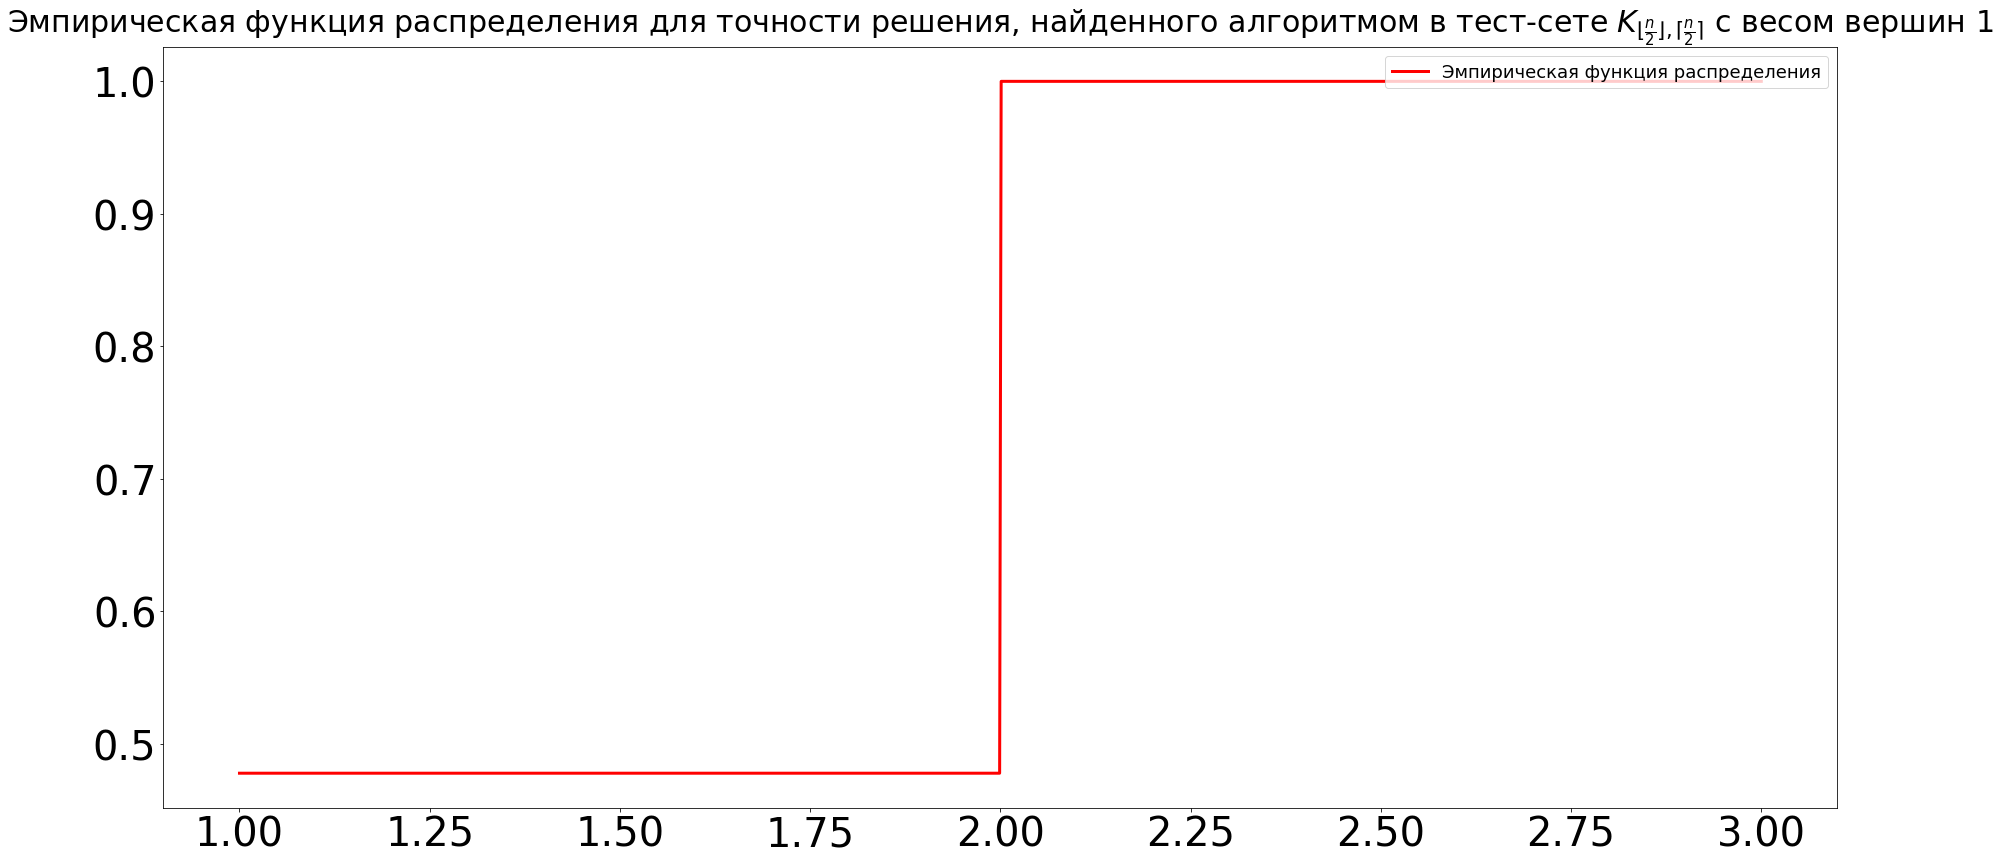

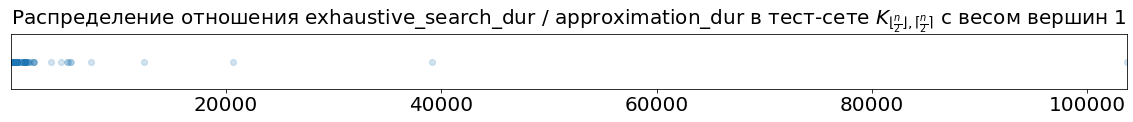

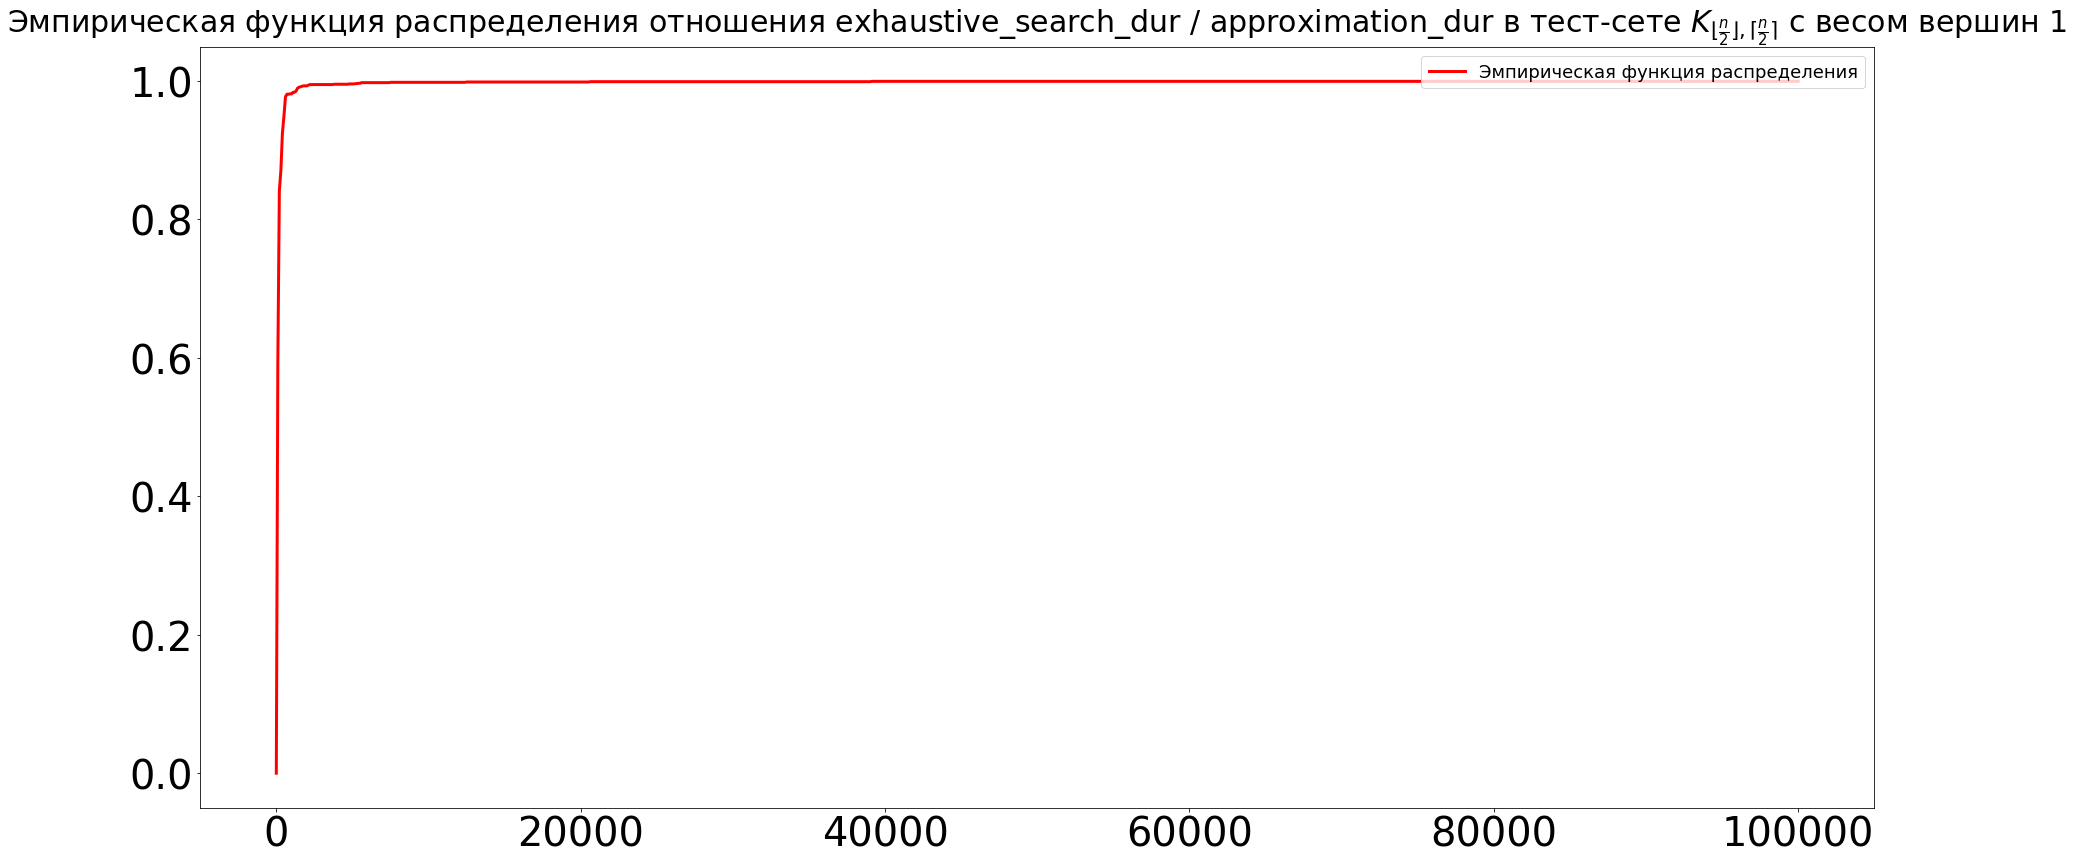

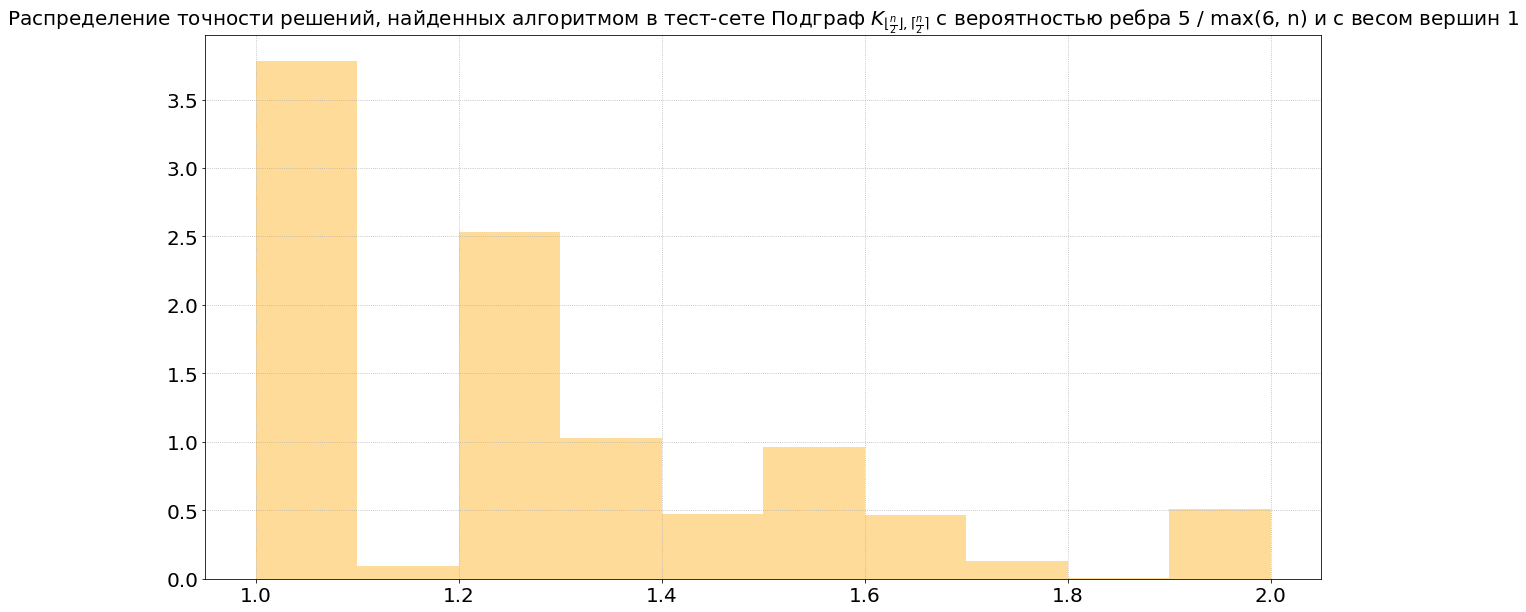

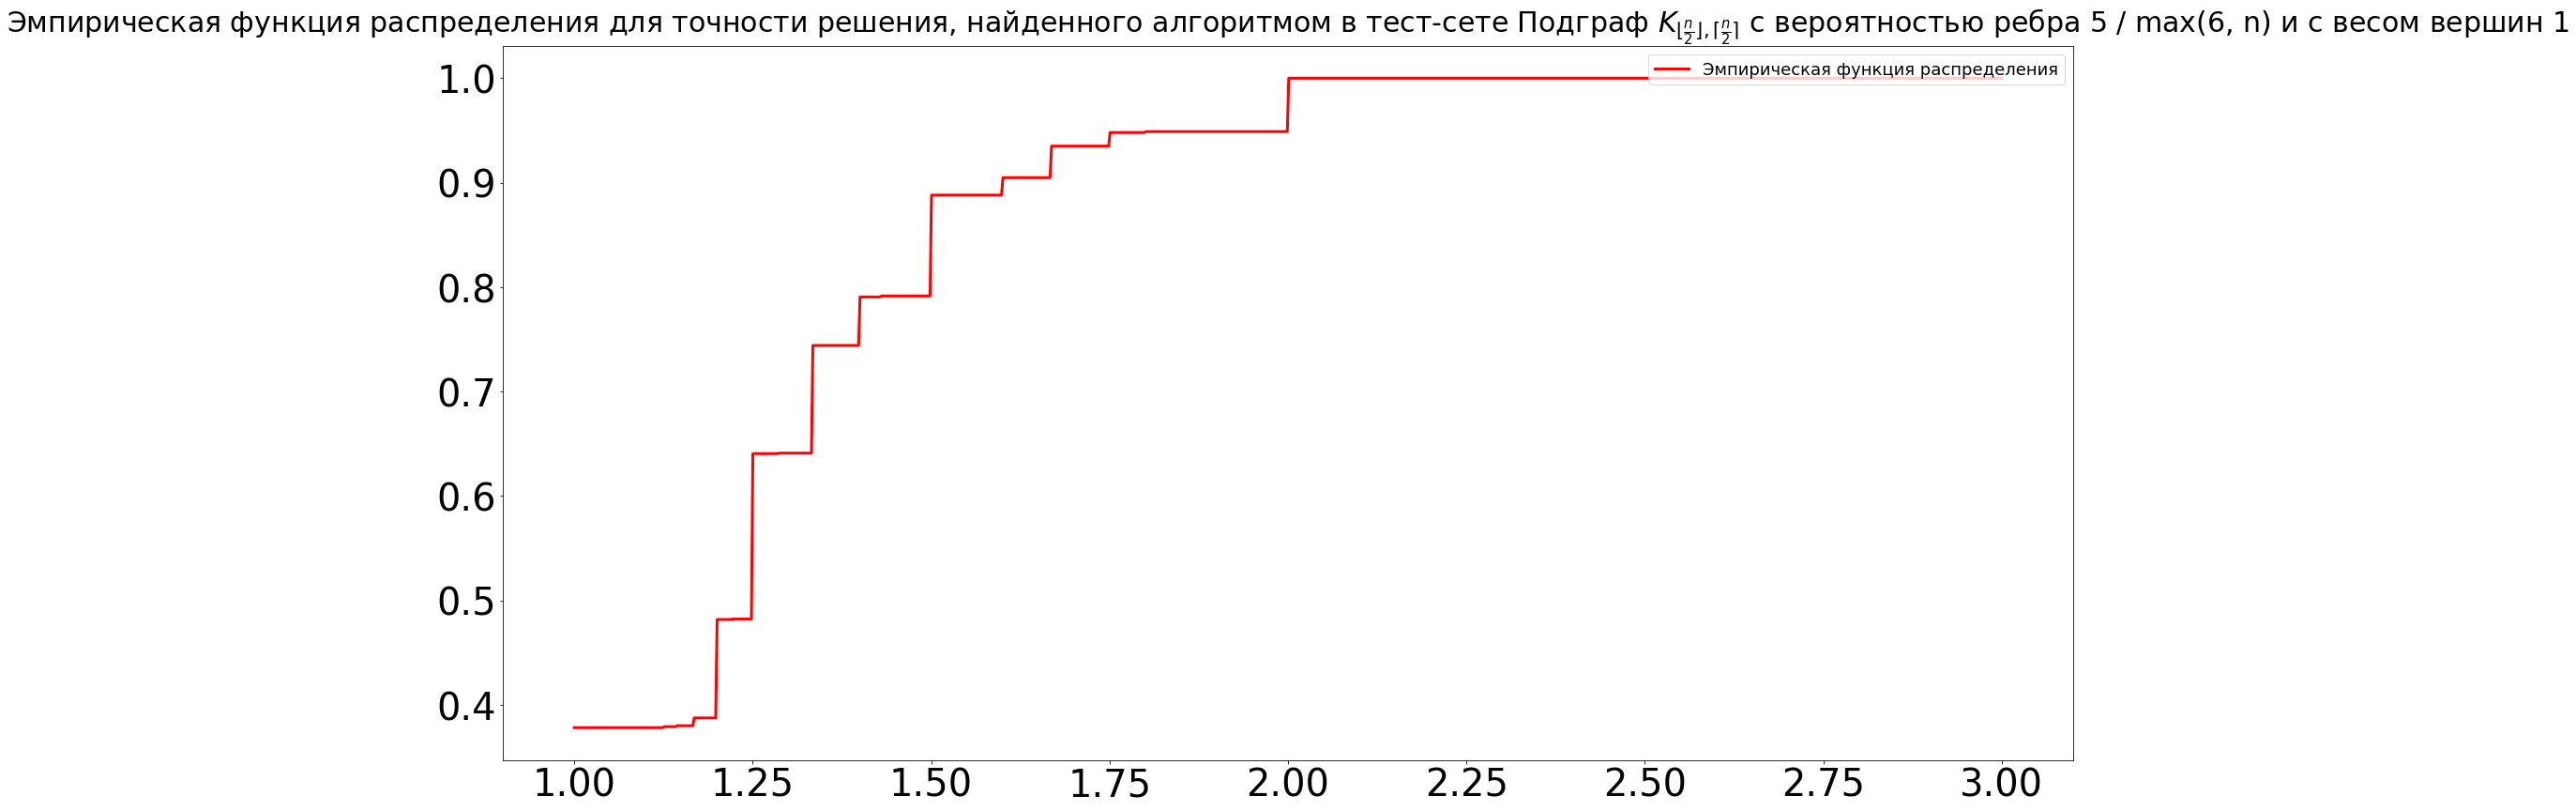

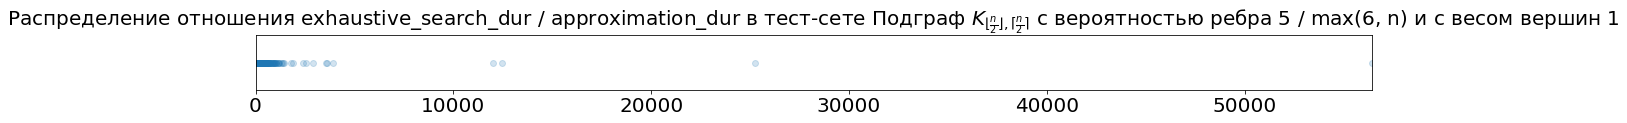

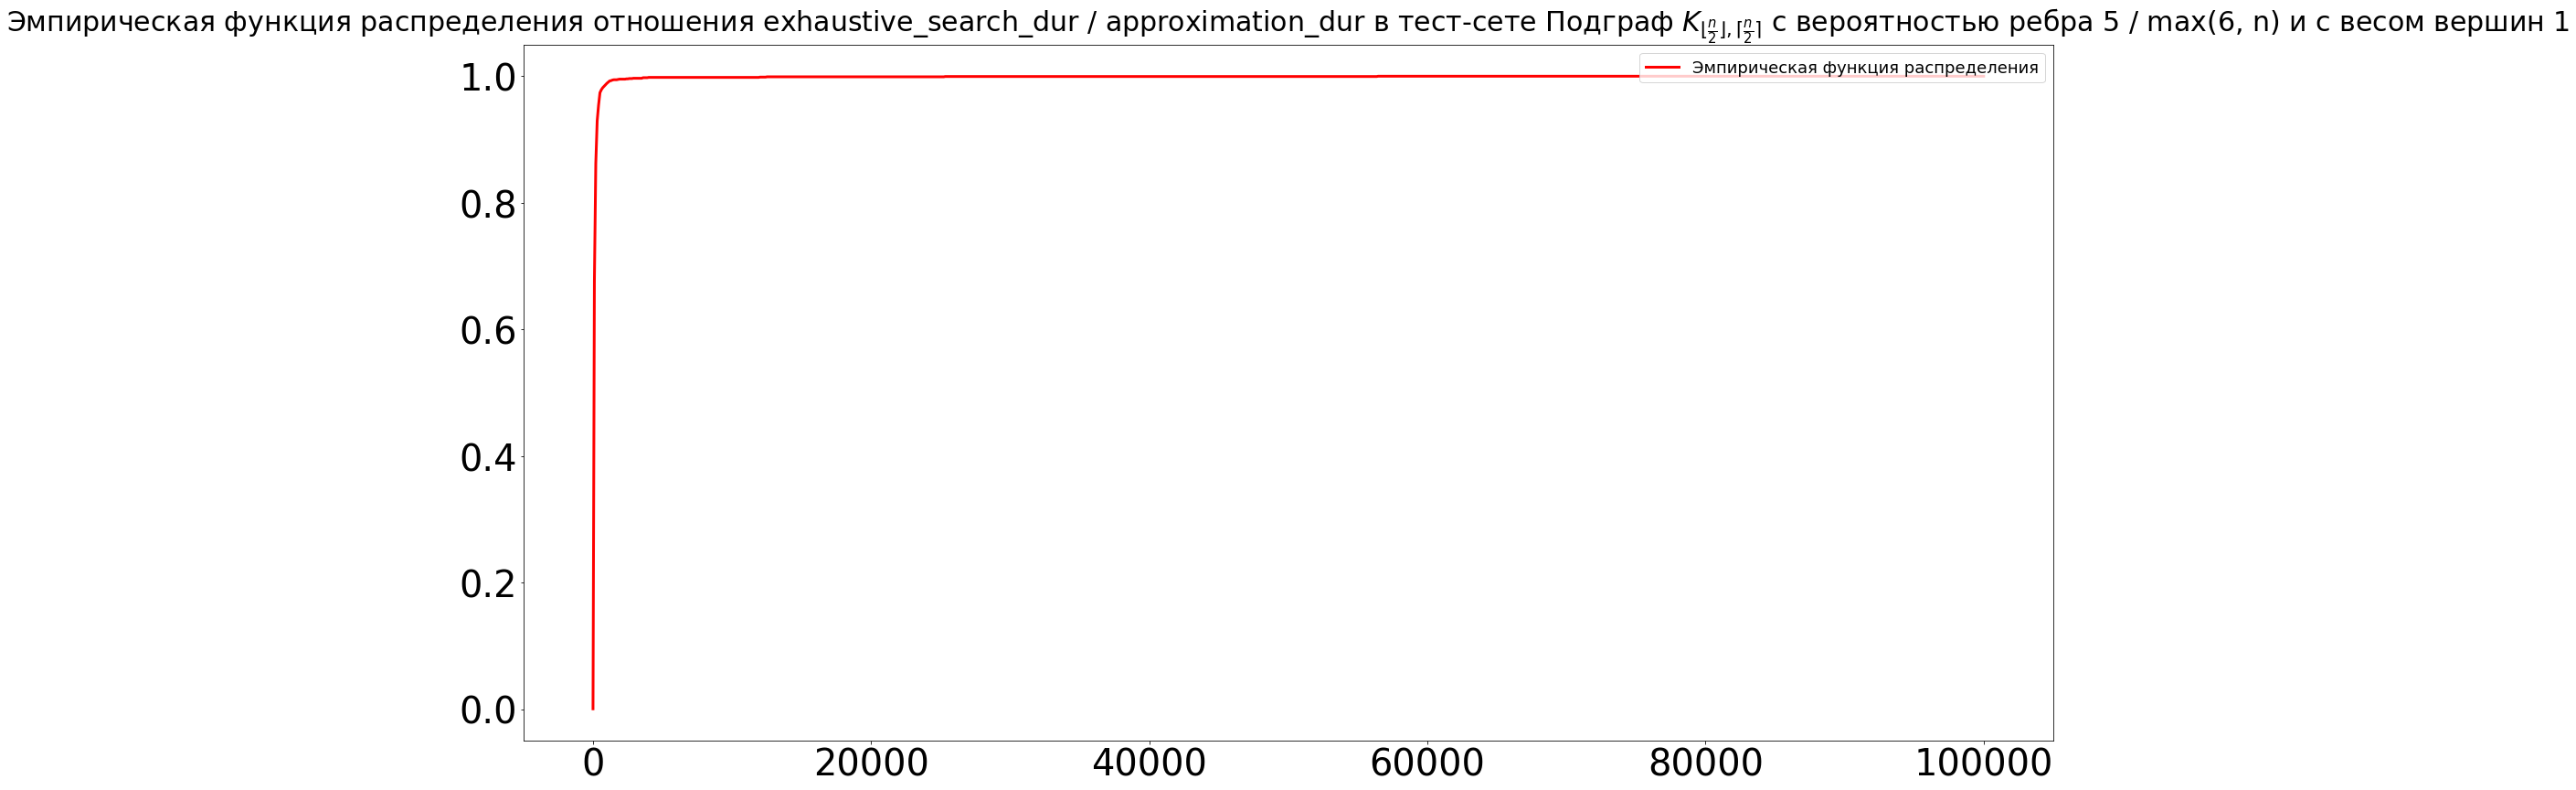

In [52]:
infile_name = './tests_input/in.txt'
outfile_name = './tests_output/out.txt'

vertex_counts = range(3, 21)
graph_counts = [2, 10, 100, 200, 300, 400, 400, 400, 200,
                100, 20, 10, 5, 2, 1, 1, 1, 1]

weight_param = lambda vertex_count : 1

p = lambda vertex_count : 0.5
analyse_tests(infile_name, outfile_name, p, weight_param,
              vertex_counts, graph_counts,
              'Подграф $K_{\\lfloor \\frac{n}{2} \\rfloor,\\lceil \\frac{n}{2} \\rceil}$' +
              ' с вероятностью ребра 0.5 и с весом вершин 1')

p = lambda vertex_count : 1
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              '$K_{\\lfloor \\frac{n}{2} \\rfloor,\\lceil \\frac{n}{2} \\rceil}$' +
              ' с весом вершин 1')

p = lambda vertex_count : 5 / np.max([6, vertex_count])
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              'Подграф $K_{\\lfloor \\frac{n}{2} \\rfloor,\\lceil \\frac{n}{2} \\rceil}$' +
              ' с вероятностью ребра 5 / max(6, n) и с весом вершин 1')

**Вывод:**

Если на подграфах $K_{\lfloor \frac{n}{2} \rfloor,\lceil \frac{n}{2} \rceil}$ с вероятностью ребра 0.5, 5 / max(6, n) и на самом $K_{\lfloor \frac{n}{2} \rfloor,\lceil \frac{n}{2} \rceil}$ взять весовую функцию, всюду равную 1, то время работы нашего алгоритма в ещё большее число раз меньше времени работы полного перебора, чем в предыдущих тестовых запусках. Точность найденных решений в целом довольно высокая в первых 2-ух случаях, но среднее и медиана немного выше чем в предыдущих запусках. Однако в случае $K_{\lfloor \frac{n}{2} \rfloor,\lceil \frac{n}{2} \rceil}$ примерно в половине случаев точность равна 1, а в другой половине она равна 2. Это, скорее всего, связано с тем, что в случае с нечетным числом вершин алгоритм находит точное решение, а в случае с четным числом вершин алгоритм ошибается в 2 раза, как показывалось в примере выше. Убедимся в этом, проведя дополнительные тесты

Сначала разберёмся со случаем, когда общее число вершин чётно.

Statistics for test-set $K_{n,n}$ с весом вершин 1:
Is correct vertex cover: 1.0
Approximation results:
max: 2.0
min: 2.0
mean: 2.0
median: 2.0
0.25-quantile: 2.0
0.75-quantile: 2.0
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 102351.58181818182
min: 3.5
mean: 245.67501062492417
median: 48.24603174603175
0.25-quantile: 35.337500000000006
0.75-quantile: 153.96249999999998



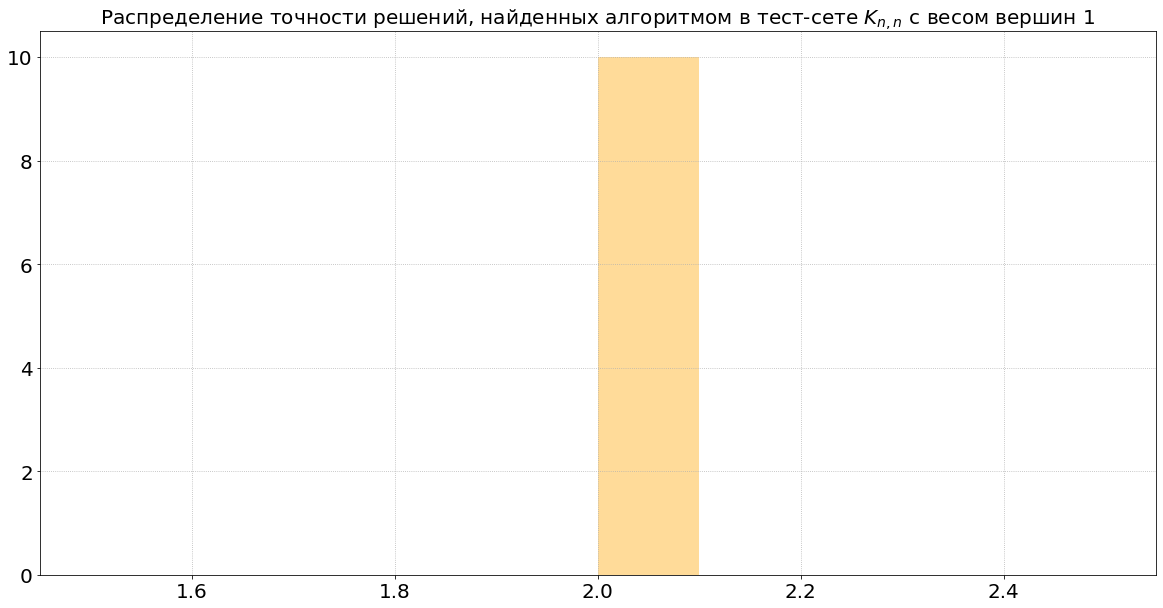

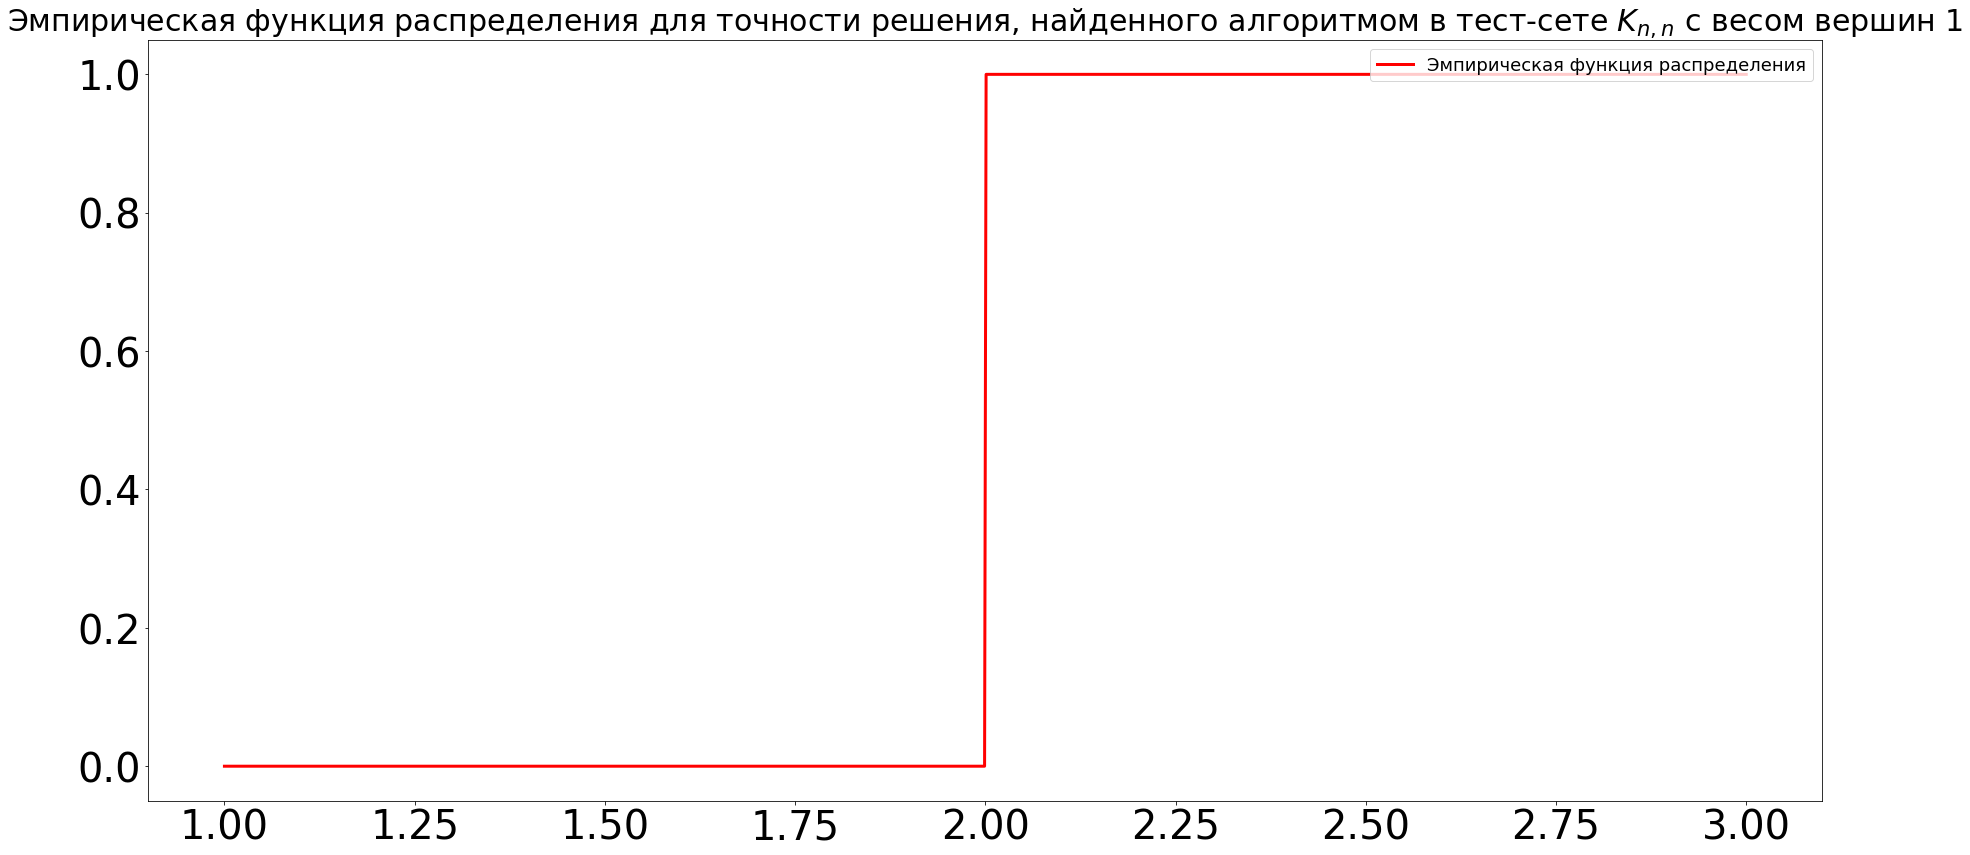

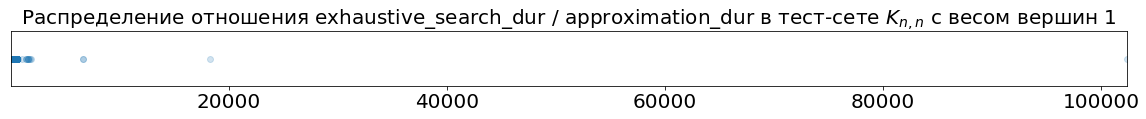

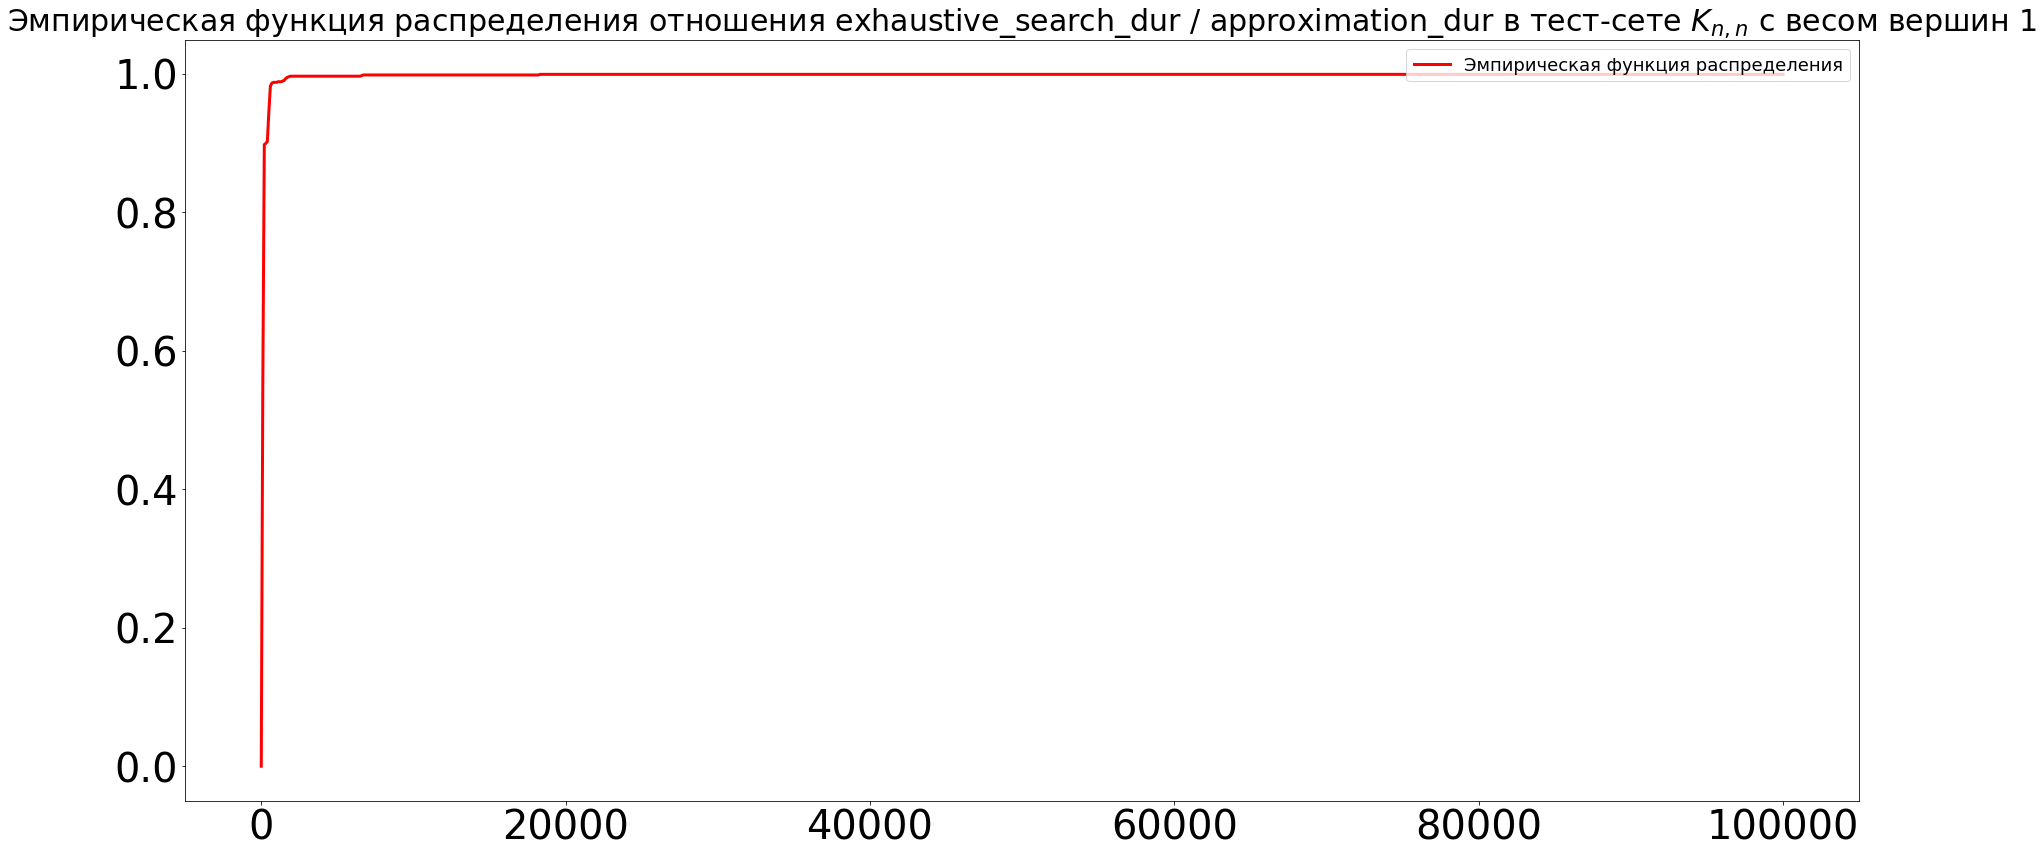

In [50]:
infile_name = './tests_input/in.txt'
outfile_name = './tests_output/out.txt'

vertex_counts = range(4, 21, 2)
graph_counts = [10, 200, 400, 400, 100, 10, 2, 1, 1]

weight_param = lambda vertex_count : 1

p = lambda vertex_count : 1
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              '$K_{n,n}$ с весом вершин 1')

Теперь рассмотрим случай, когда общее число вершин нечётно.

Statistics for test-set $K_{n,n+1}$ с весом вершин 1:
Is correct vertex cover: 1.0
Approximation results:
max: 1.0
min: 1.0
mean: 1.0
median: 1.0
0.25-quantile: 1.0
0.75-quantile: 1.0
Time measuring results (exhaustive_search_dur / approximation_dur):
max: 63759.232558139534
min: 1.6666666666666667
mean: 163.61139675599676
median: 32.2
0.25-quantile: 24.615384615384617
0.75-quantile: 103.73214285714285



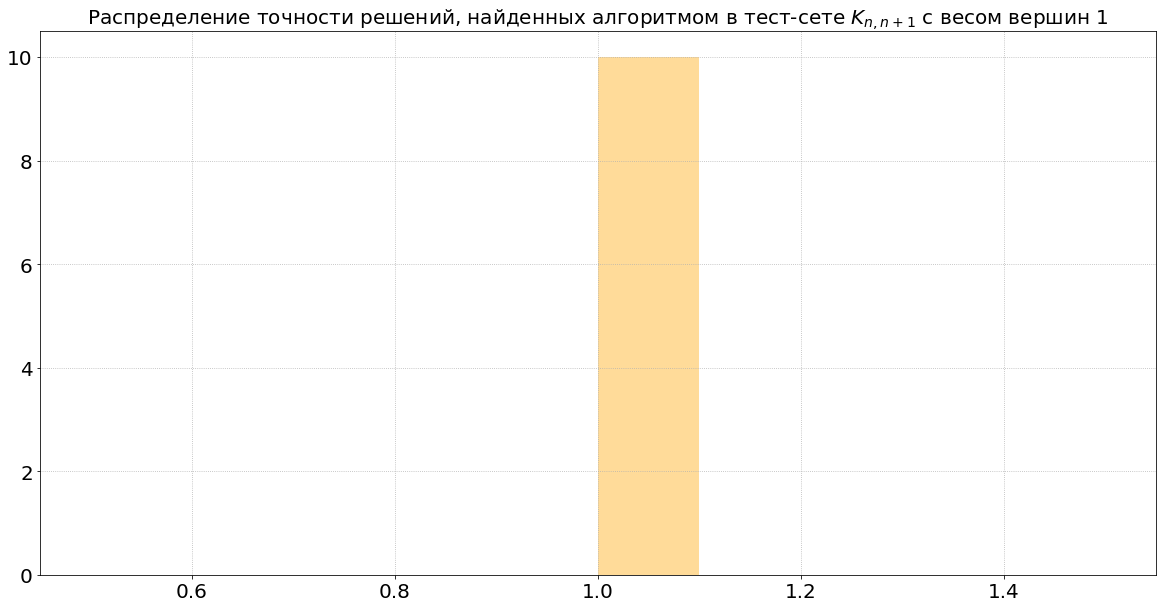

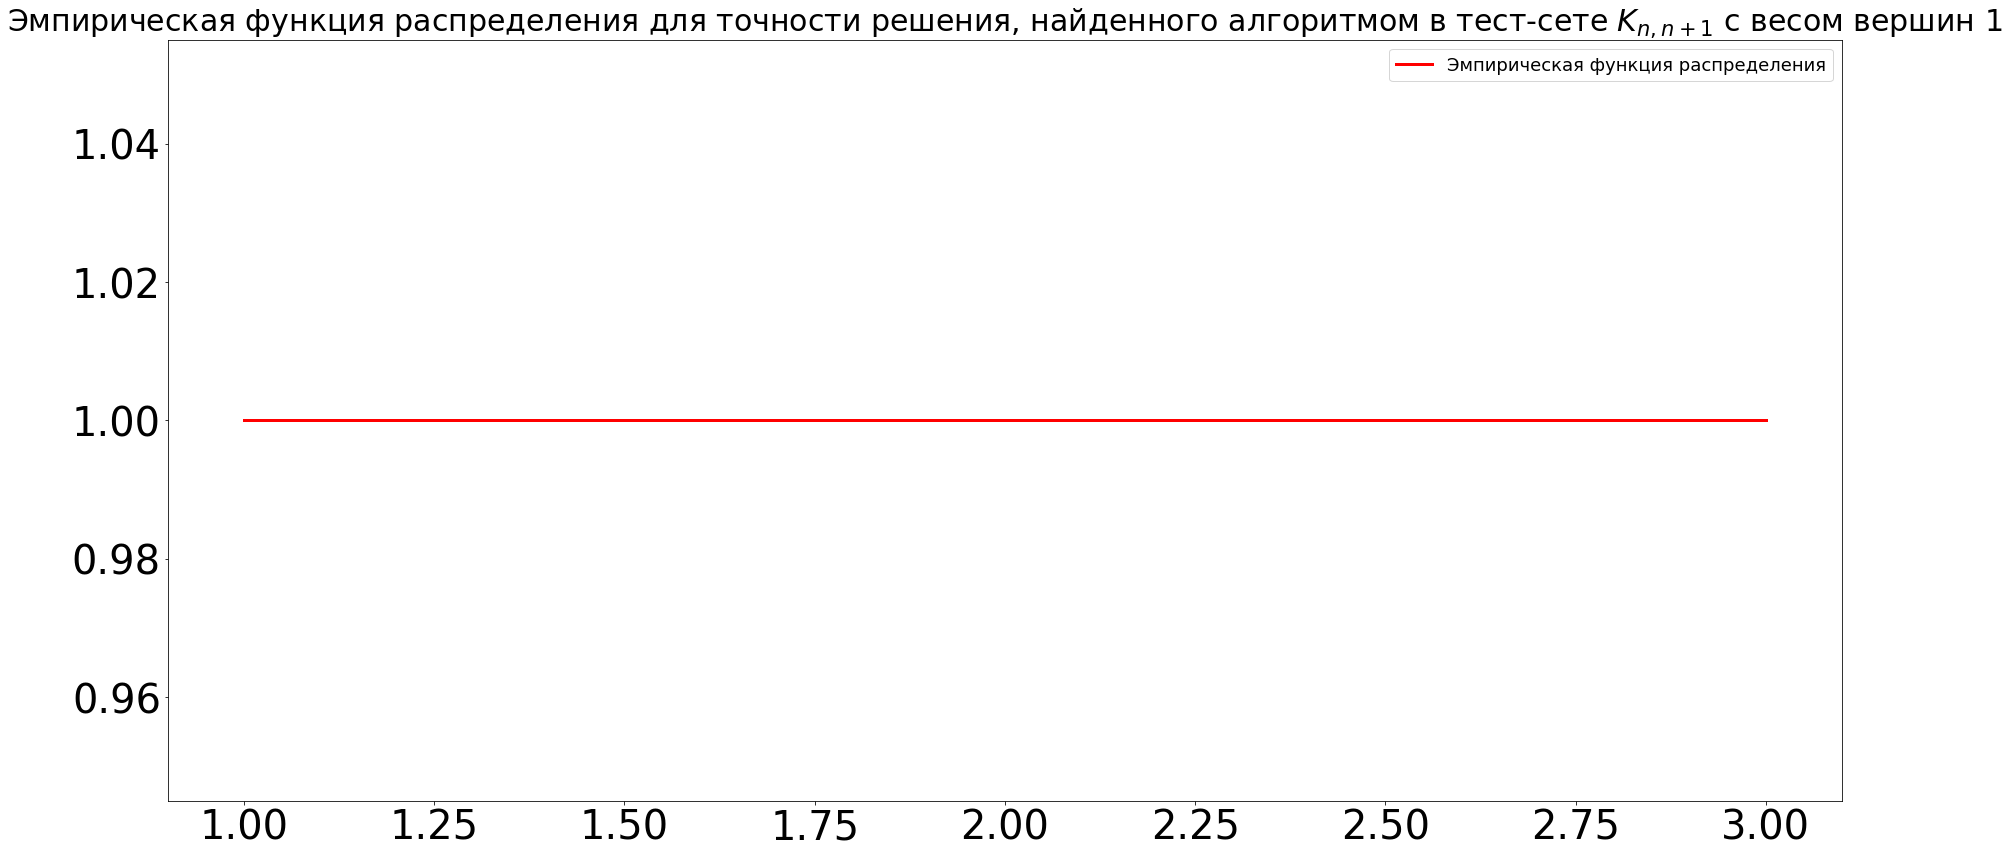

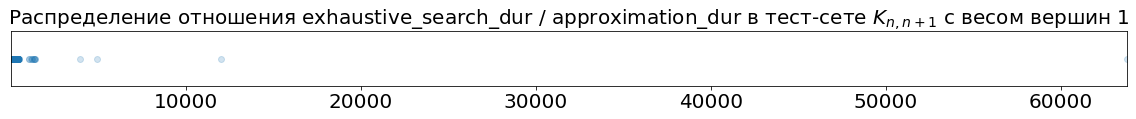

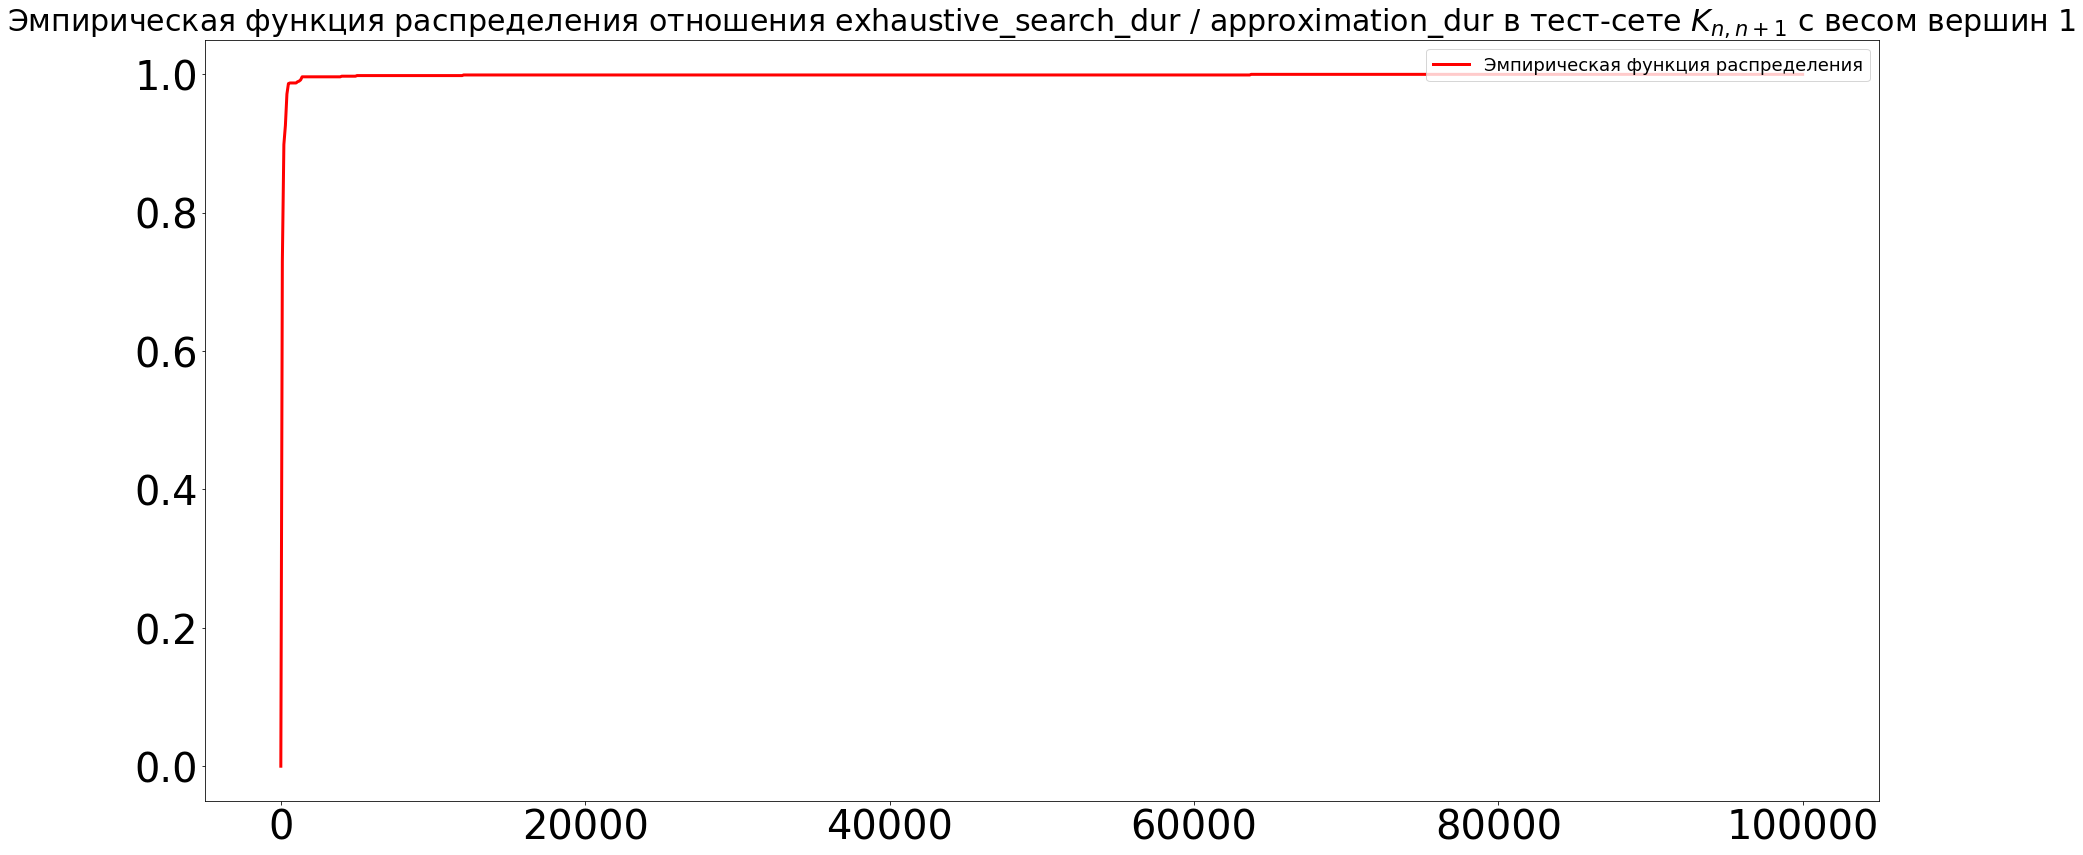

In [51]:
infile_name = './tests_input/in.txt'
outfile_name = './tests_output/out.txt'

vertex_counts = range(3, 20, 2)
graph_counts = [10, 200, 400, 400, 100, 10, 2, 1, 1]

weight_param = lambda vertex_count : 1

p = lambda vertex_count : 1
analyse_tests(infile_name, outfile_name, p, weight_param, vertex_counts, graph_counts,
              '$K_{n,n+1}$ с весом вершин 1')

**Вывод:**

Точность алгоритма оказалась довольно высокой в случае $G(n, p)$, клик, двудольных графов, не являющихся $K_{n,n}$. Кроме того, на графах $K_{n,n+1}$ точность равна 1, а на графах $K_{n,n}$, наоборот, достигается теоретическая оценка: точность равна 2.

Время работы алгоритма гораздо меньше времени полного перебора.